# Desafio Data Science EDS

Autora: Beatriz de Araújo Andrade

##Problema

Uma empresa de telecomunicações está em busca de reduzir a taxa de abandono de seus clientes. Com esse objetivo em mente, o foco está na construção de um modelo preditivo capaz de identificar, utilizando dados históricos e atributos específicos, a probabilidade de um cliente se tornar inativo em um período determinado. Caso essa probabilidade ultrapasse um limite estabelecido pela empresa, serão acionadas medidas de retenção, considerando que os custos associados à retenção de clientes são inferiores aos custos de aquisição.

Para abordar essa questão, adotaremos uma estratégia de classificação binária. Isso implicará na correção de erros nos dados, no tratamento de desequilíbrios nas amostras, em uma análise exploratória abrangente dos dados e na realização de engenharia de atributos para adequar as variáveis ao treinamento do modelo. Em seguida, testaremos vários modelos de classificação e selecionaremos aquele que oferecer o melhor desempenho, com base em métricas pré-definidas.

## Preparação do Ambiente e Carregamento dos Dados

In [225]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import joblib

In [128]:
train = pd.read_csv('churn-80.csv')
test = pd.read_csv('churn-20.csv')

## Contextualização dos Dados

Vamos explorar o formato e significado dos dados de treinamento e teste

In [129]:
train.shape

(2666, 20)

In [130]:
test.shape

(667, 20)

In [131]:
train.head(10)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,No,Yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,Yes,No,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,WV,141,415,Yes,Yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False
9,RI,74,415,No,No,0,187.7,127,31.91,163.4,148,13.89,196.0,94,8.82,9.1,5,2.46,0,False


In [132]:
train.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

Após uma análise preliminar dos conjuntos de dados, notamos que temos uma quantidade limitada de dados disponíveis para treinamento e teste do modelo. O conjunto de treinamento possui 2666 amostras, enquanto o conjunto de teste possui 667 amostras.

O conjunto de dados consiste em 15 variáveis numéricas e 5 variáveis categóricas, sendo uma delas a variável alvo.

**Variáveis categóricas:**

- **State**: Multiclasse - sigla que indica o estado dos EUA onde o cliente reside.
- **Area code**: Multiclasse - código de 3 dígitos que identifica áreas de serviço telefônico.
- **International plan**: Binário - indica se o cliente assina o plano internacional.
- **Voice mail plan**: Binário - indica se o cliente assina o plano de mensagens de voz.
- **Churn** (alvo): Binário - indica se houve churn.

**Variáveis numéricas:**

- **Account length**: Número de meses que o cliente utiliza os serviços da empresa.
- **Number vmail messages**: Número de mensagens de voz enviadas.
- **Total day minutes**: Total de minutos das chamadas diurnas.
- **Total day calls**: Número de chamadas realizadas durante o dia.
- **Total day charge**: Valor gasto devido às chamadas diurnas.
- **Total eve minutes**: Total de minutos das chamadas vespertinas.
- **Total eve calls**: Número de chamadas realizadas durante a tarde.
- **Total eve charge**: Custo total das chamadas vespertinas.
- **Total night minutes**: Total de minutos das chamadas noturnas.
- **Total night calls**: Número de chamadas realizadas durante a noite.
- **Total night charge**: Custo total das chamadas noturnas.
- **Total intl minutes**: Total de minutos das chamadas internacionais.
- **Total intl calls**: Número de chamadas internacionais.
- **Total intl charge**: Custo total das chamadas internacionais.
- **Customer service calls**: Número de chamadas feitas ao suporte ao cliente.

## Pré-processamento dos Dados

Nessa etapa, verificaremos os seguintes pontos:
- Corretude dos tipos dos atributos
- A presença de valores nulos
- A existência de valores duplicados
- Se há erros de formatação

In [133]:
#Imprime informações gerais sobre as colunas do dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

Podemos observar que o dado categórico "Area code" está atualmente representado como int64. No entanto, como os valores dessa variável são utilizados apenas para identificar áreas de serviço telefônico e não possuem relevância matemática, é apropriado converter essa variável para o tipo object. Quanto às outras variáveis, seus tipos estão adequados às suas categorias e não requerem alterações.

In [135]:
#Conversão de Area code para object nos dados de treinamento
train['Area code'] = train['Area code'].astype(object)
train.dtypes

State                      object
Account length              int64
Area code                  object
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [136]:
#Conversão de Area code para object nos dados de teste
test['Area code'] = test['Area code'].astype(object)
test.dtypes

State                      object
Account length              int64
Area code                  object
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [137]:
#Contabiliza a quantidade de valores nulos por atributo nos dados de treinamento
train.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

In [138]:
#Contabiliza a quantidade de valores nulos por atributo nos dados de teste
test.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

**Não foram encontrados valores nulos nos conjuntos de dados de treinamento e teste.**

In [139]:
#Verifica se há dados duplicados no conjunto de treinamento
train.duplicated().any()

False

In [140]:
#Verifica se existem dados duplicados no conjunto de teste
test.duplicated().any()

False

**Não foram encontrados dados duplicados nos conjuntos de dados de treinamento e teste.**




Para verificar a ocorrência de erros de formatação, iremos analisar a quantidade e os valores únicos de cada variável categórica.

In [141]:
#Contabiliza os valores únicos em cada variável categórica (treinamento)
train.select_dtypes(include=['object', 'bool']).nunique()

State                 51
Area code              3
International plan     2
Voice mail plan        2
Churn                  2
dtype: int64

In [142]:
#Contabiliza os valores únicos em cada variável categórica (teste)
test.select_dtypes(include=['object', 'bool']).nunique()

State                 51
Area code              3
International plan     2
Voice mail plan        2
Churn                  2
dtype: int64

In [143]:
#Função que imprime os valores únicos de cada variável categórica de um dataframe
def print_unique_values_cat(df):
  for col in df.select_dtypes(include=['object', 'bool']).columns:
    print(col, ':' , df[col].unique(), '\n')

In [144]:
#Imprime os valores únicos das variáveis categóricas dos dados de treinamento
print_unique_values_cat(train)

State : ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'WV' 'RI' 'IA' 'MT' 'ID' 'VT' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'NE' 'WY' 'IL' 'NH' 'LA' 'GA' 'AK' 'MD' 'AR' 'WI'
 'OR' 'DE' 'IN' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'NY' 'KY'
 'ME' 'MS' 'MI' 'SC' 'TN' 'PA' 'HI' 'ND' 'CT'] 

Area code : [415 408 510] 

International plan : ['No' 'Yes'] 

Voice mail plan : ['Yes' 'No'] 

Churn : [False  True] 



In [145]:
#Imprime os valores únicos das variáveis categóricas dos dados de teste
print_unique_values_cat(test)

State : ['LA' 'IN' 'NY' 'SC' 'HI' 'AK' 'MI' 'ID' 'VA' 'WI' 'MN' 'VT' 'MT' 'MA'
 'KY' 'CO' 'AZ' 'CA' 'WA' 'NE' 'OH' 'MO' 'AL' 'NH' 'NM' 'OR' 'TX' 'MS'
 'WY' 'FL' 'KS' 'NC' 'SD' 'OK' 'CT' 'RI' 'DE' 'UT' 'NV' 'DC' 'ME' 'IL'
 'NJ' 'MD' 'WV' 'PA' 'ND' 'AR' 'TN' 'IA' 'GA'] 

Area code : [408 415 510] 

International plan : ['No' 'Yes'] 

Voice mail plan : ['No' 'Yes'] 

Churn : [False  True] 



Podemos observar que não há erros de formatação e que os valores únicos das variáveis categóricas são consistentes entre os conjuntos de dados de treinamento e teste.

## Análise exploratória dos dados

Nesta seção, iremos abordar os seguintes pontos:

- Medidas da estatística descritiva dos dados de treinamento.
- Distribuição de cada variável.
- Exploração da relação das variáveis com o churn.
- Análise de correlação entre as variáveis numéricas.
- Identificação e tratamento de outliers.

### Análise da distribuição das variáveis

In [146]:
#Gera um resumo estatístico descritivo das variáveis numéricas
train.describe()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Podemos observar que a maioria das variáveis numéricas apresenta valores de média e mediana (50%) muito próximos, sugerindo uma ausência ou presença mínima de valores extremos nos dados. Uma exceção é a variável "Number vmail messages", onde metade dos dados possui valor 0, enquanto o terceiro quartil indica um valor de 19, possivelmente indicando uma distribuição bimodal, a ser investigada posteriormente.

Outras variáveis, como "Total intl calls" e "Customer service calls", também mostram uma diferença maior entre média e mediana, embora não tão acentuada quanto "Number vmail messages", com variações de 0.46 e 0.56, respectivamente. Observando os quartis, nota-se uma concentração dos dados nos valores menores, indicando uma distribuição levemente right-skewed. Para as demais variáveis, prevê-se uma distribuição normal.

In [147]:
#resumo estatístico das variáveis categóricas e booleanas no DataFrame train
train.describe(include=['object', 'bool'])

,State,Area code,International plan,Voice mail plan,Churn
count,2666,2666,2666,2666,2666
unique,51,3,2,2,2
top,WV,415,No,No,False
freq,88,1318,2396,1933,2278


Sobre as variáveis categóricas, podemos observar que a categoria "415" da variável "Area code" representa quase metade dos dados. Além disso, quase 90% dos clientes não possuem um plano internacional e mais de 70% não possuem um plano que cobre mensagens de voz.

Também é importante notar que menos de 15% dos dados da variável alvo representam a nossa classe de interesse (churn == True), o que indica um desbalanceamento nos dados. Mais tarde, teremos que lidar com isso para evitar que o modelo se torne enviesado.

array([[<Axes: title={'center': 'Account length'}>,
        <Axes: title={'center': 'Number vmail messages'}>,
        <Axes: title={'center': 'Total day minutes'}>,
        <Axes: title={'center': 'Total day calls'}>],
       [<Axes: title={'center': 'Total day charge'}>,
        <Axes: title={'center': 'Total eve minutes'}>,
        <Axes: title={'center': 'Total eve calls'}>,
        <Axes: title={'center': 'Total eve charge'}>],
       [<Axes: title={'center': 'Total night minutes'}>,
        <Axes: title={'center': 'Total night calls'}>,
        <Axes: title={'center': 'Total night charge'}>,
        <Axes: title={'center': 'Total intl minutes'}>],
       [<Axes: title={'center': 'Total intl calls'}>,
        <Axes: title={'center': 'Total intl charge'}>,
        <Axes: title={'center': 'Customer service calls'}>, <Axes: >]],
      dtype=object)

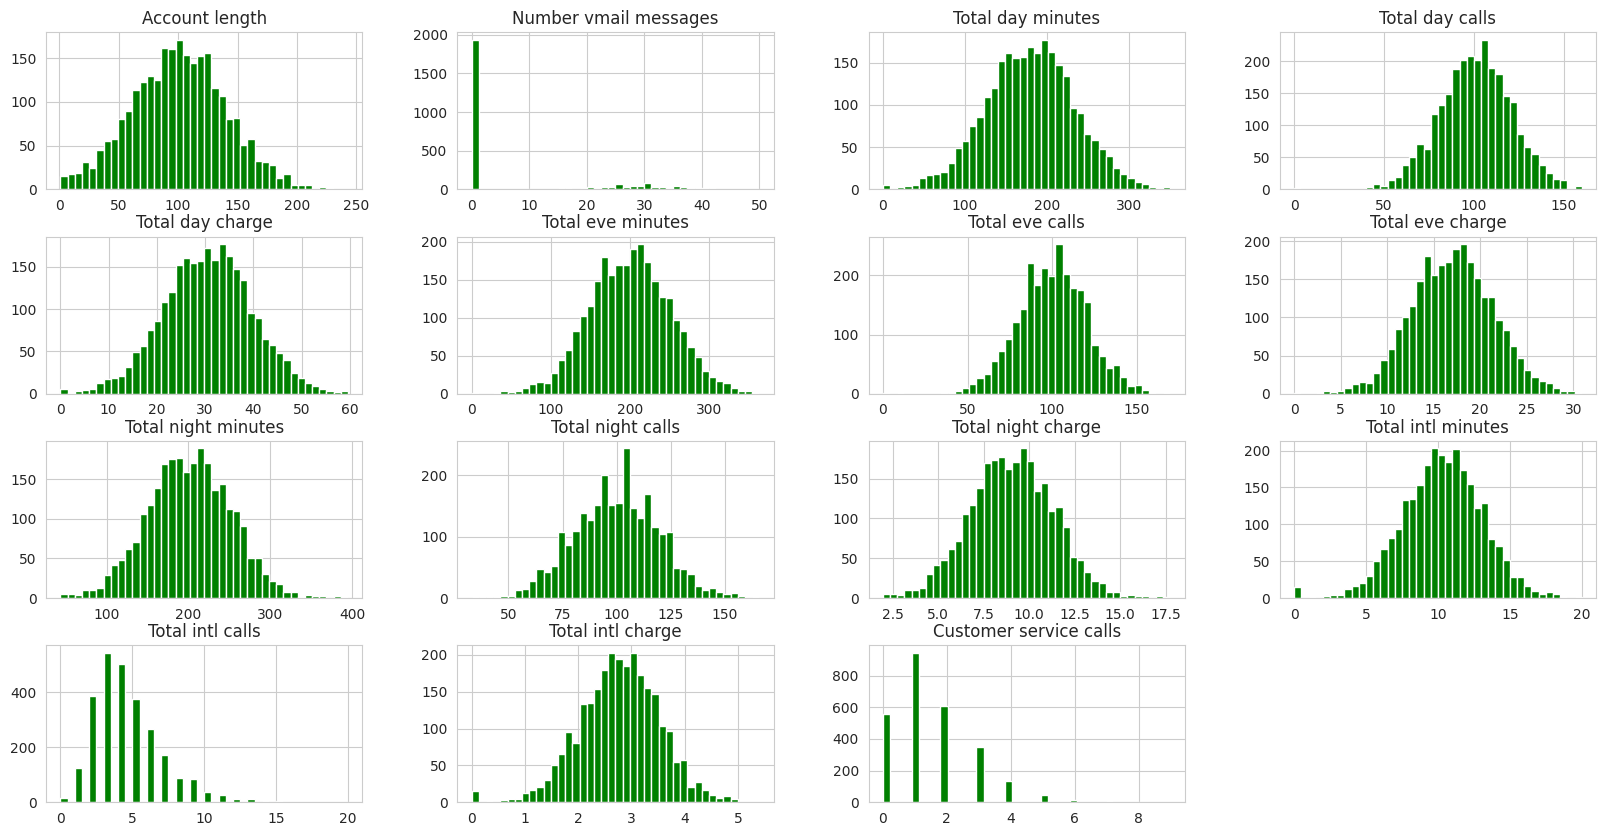

In [148]:
#plota um histograma sobre todas as variáveis numéricas do conjunto de treinamento
train.hist(figsize=(20, 10), color='green', bins=40)

Ao analisar esses histogramas, podemos confirmar as hipóteses anteriormente formuladas sobre as distribuições dos dados numéricos.

In [149]:
#Função que cria um countplot conforme a coluna e o dataframe passados como parâmetros
def count_plot_with_perc(col, df):
  plt.figure(figsize=(20, 10))

  #Cria o count plot
  ax = sns.countplot(x=col, data=df, palette='viridis', width=0.4)

  #Calcula a porcentagem de cada categoria
  total = len(df[col])
  for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x() + p.get_width() / 2.,
              height + 3,
              '{:.2f}%'.format((height / total) * 100),
              ha="center")

  #Ajusta a legenda dos eixos
  plt.xlabel(col)
  plt.ylabel('Count')

  plt.show()

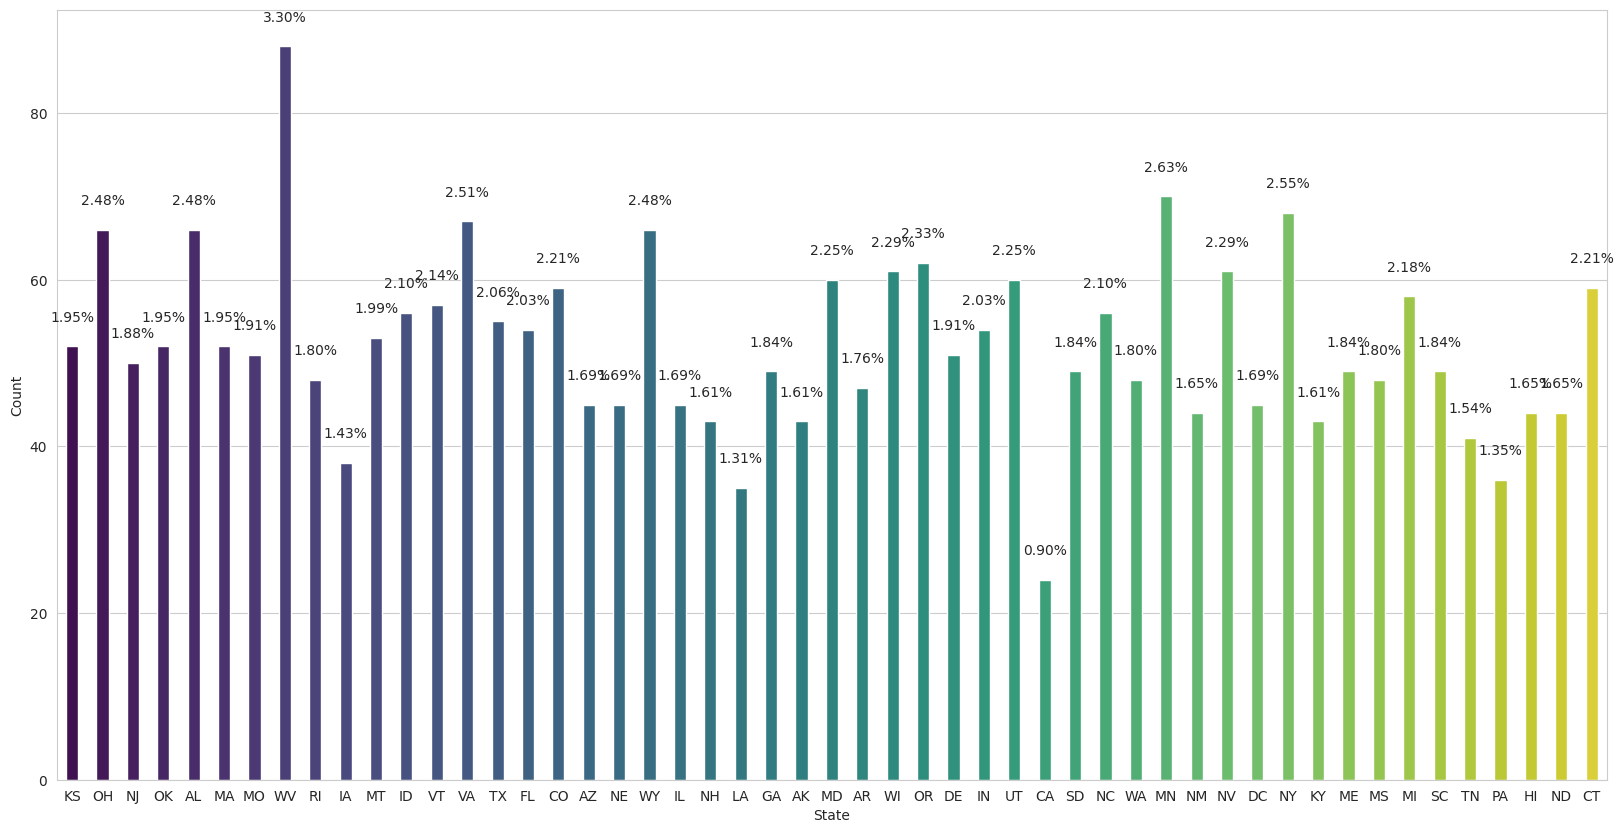

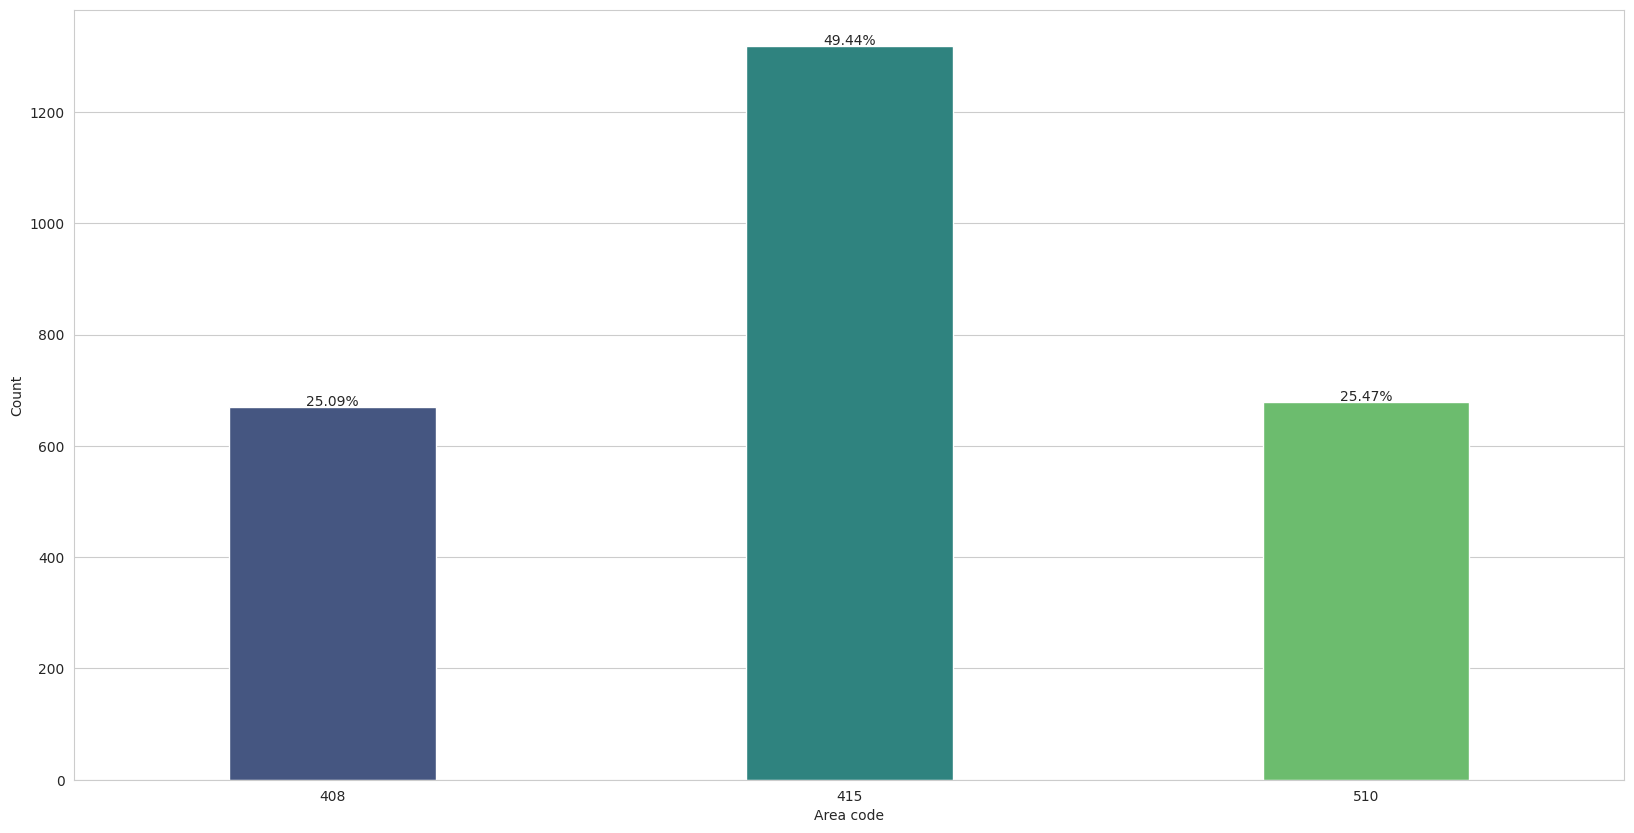

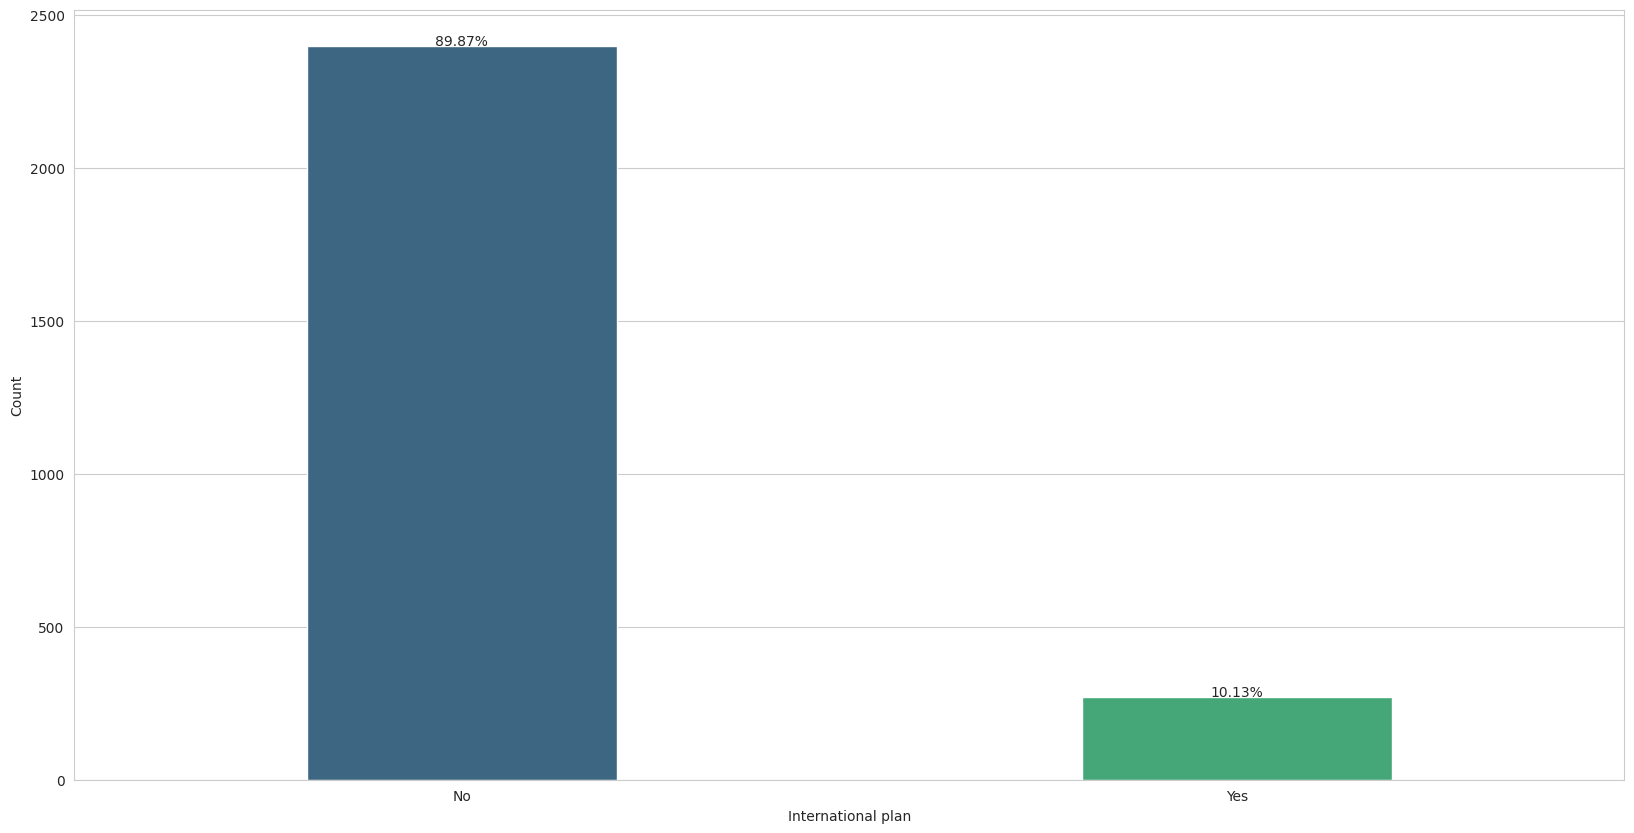

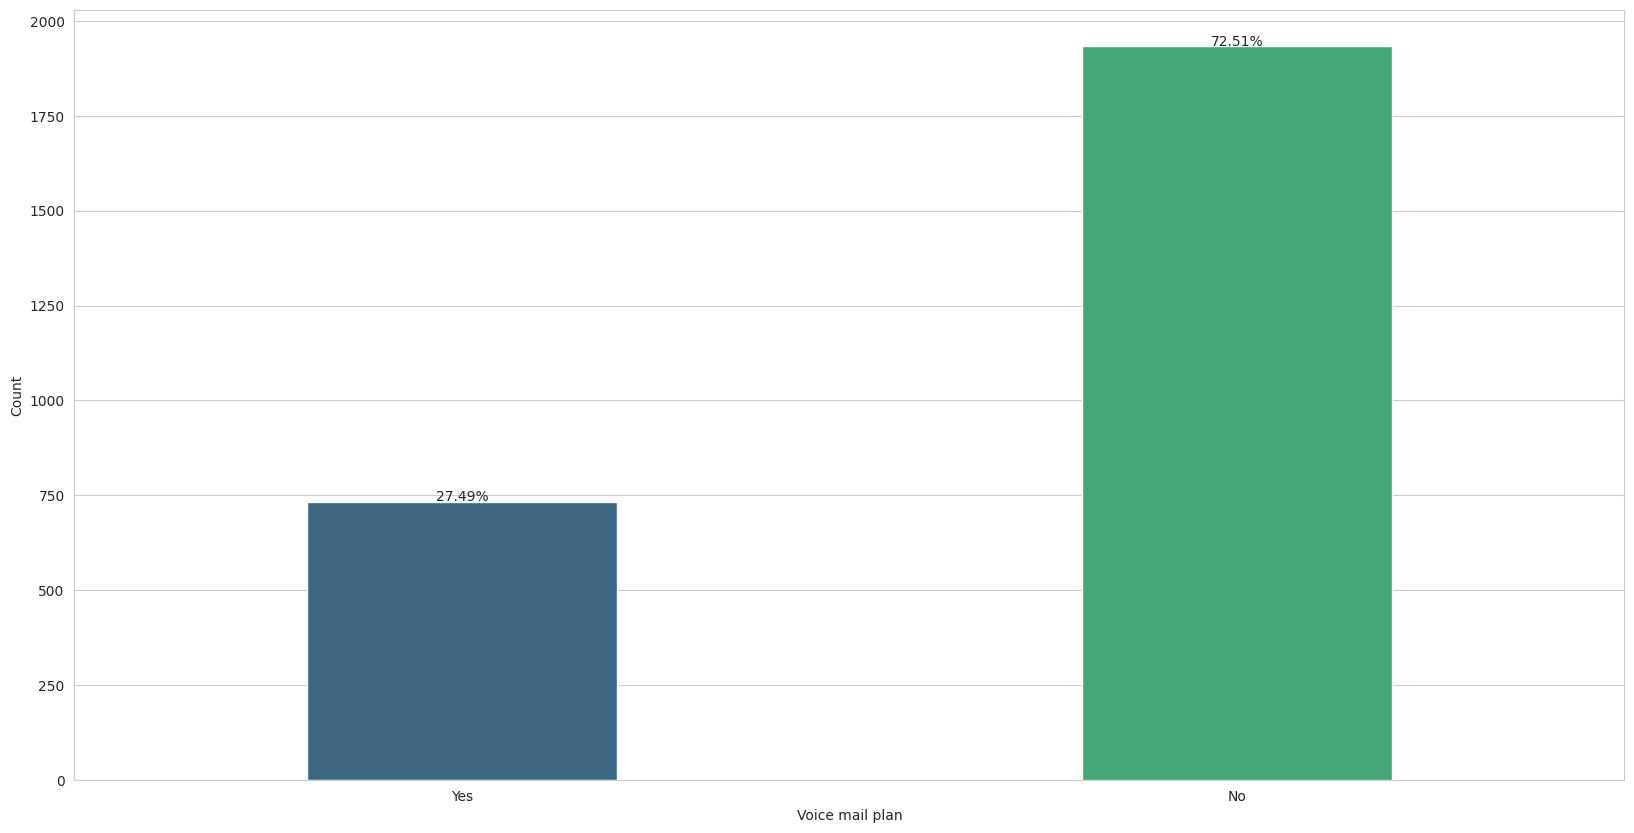

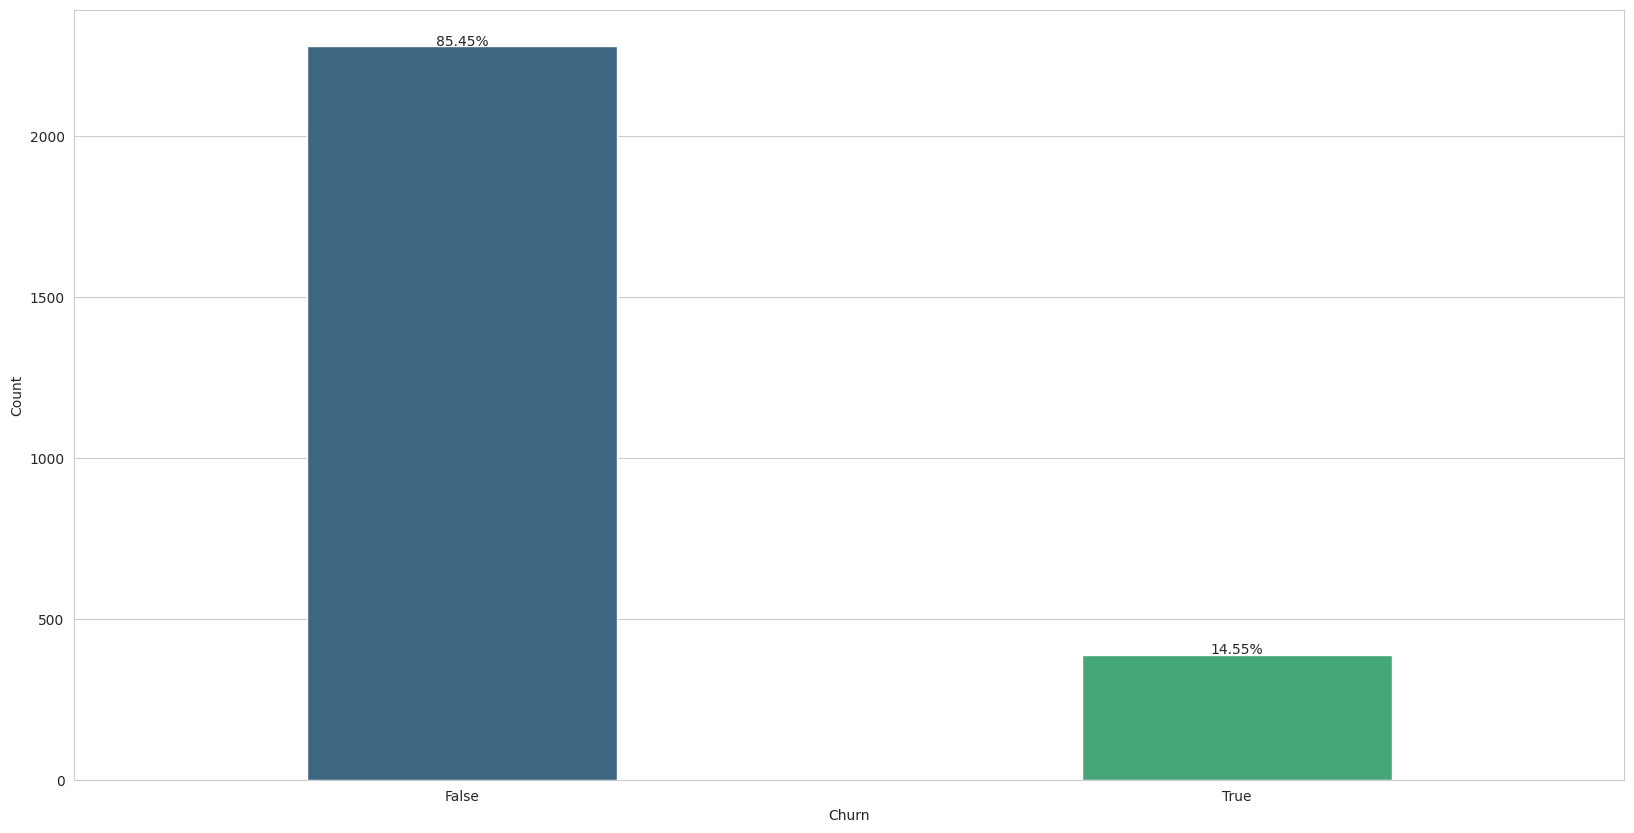

In [150]:
  #Cria um countplot para cada variável categórica
  for col in train.select_dtypes(include=['object', 'bool']).columns:
    count_plot_with_perc(col, train)

Ao analisar os gráficos, podemos confirmar as hipóteses anteriormente formuladas sobre as distribuições dos dados categóricos. Além disso, a distribuição de clientes por estado parece não apresentar grandes variações, o que pode sugerir que essa variável possivelmente não tenha um grande impacto sobre o churn geral. No entanto, para verificar se essa suposição é verdadeira, analisaremos posteriormente a relação entre a variável citada e o churn.

### Análise dos relacionamentos entre variáveis

**Variáveis núméricas x Variáveis numéricas**

In [151]:
#Função que plota a matriz de correlação de um dataframe
def plot_corr_heatmap(df):
  #Gera a matriz de correlação
  correlation_matrix = df.select_dtypes(exclude=['object', 'bool']).corr()

  #Cria uma máscara para esconder o triângulo de cima -> valores repetidos
  mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

  #Plota o heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=~mask)
  plt.title('Correlation Heatmap')
  plt.show()

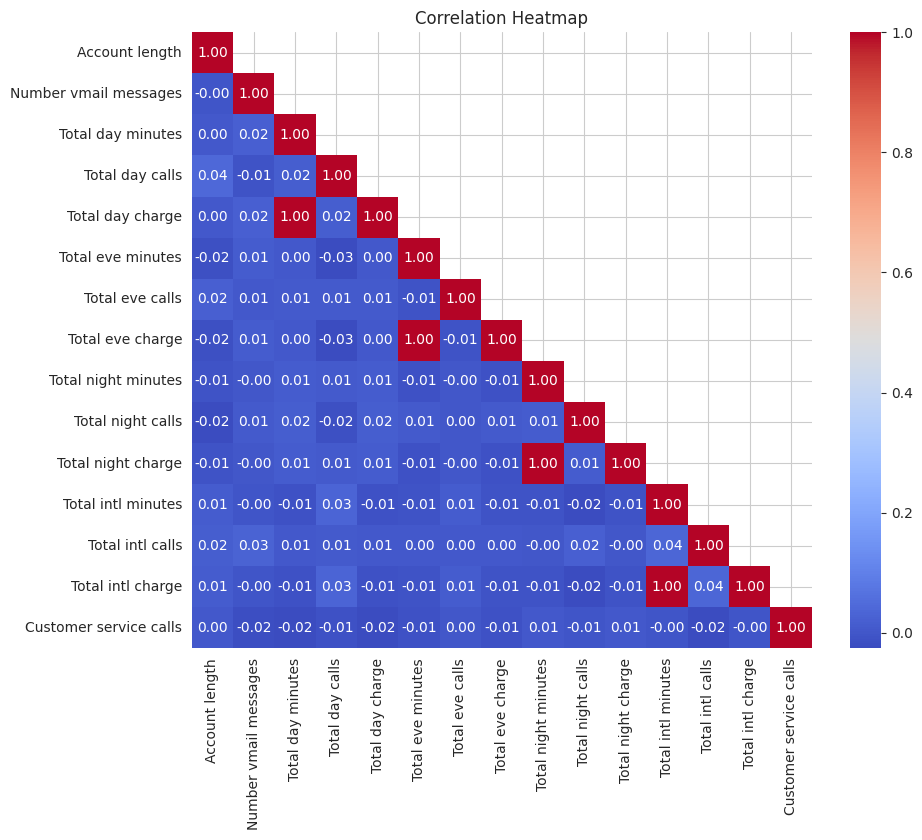

In [73]:
plot_corr_heatmap(train)

Observamos uma forte correlação entre as variáveis de custo e de minutos. Para evitar problemas de multicolinearidade no modelo, optamos por remover as colunas de 'charge', uma vez que os valores podem ser derivados da multiplicação dos 'total minutes' por uma tarifa constante, tornando-os redundantes para a análise. No entanto, para não perder a informação, criaremos uma nova variável chamada 'total charge' que representa o valor total cobrado para todos os tipos de ligações.

In [152]:
#Cria a coluna que armazena o gasto total do cliente
train['Total charges'] = train['Total night charge'] + train['Total day charge'] + train['Total eve charge'] + train['Total intl charge']
test['Total charges'] = test['Total night charge'] + test['Total day charge'] + test['Total eve charge'] + test['Total intl charge']

In [153]:
#Remoção das colunas que apresentam alto indice de correlação com total minutes
train.drop(columns=['Total night charge', 'Total eve charge', 'Total intl charge', 'Total day charge'], inplace=True)
test.drop(columns=['Total night charge', 'Total eve charge', 'Total intl charge', 'Total day charge'], inplace=True)

**Variáveis numéricas x Churn**

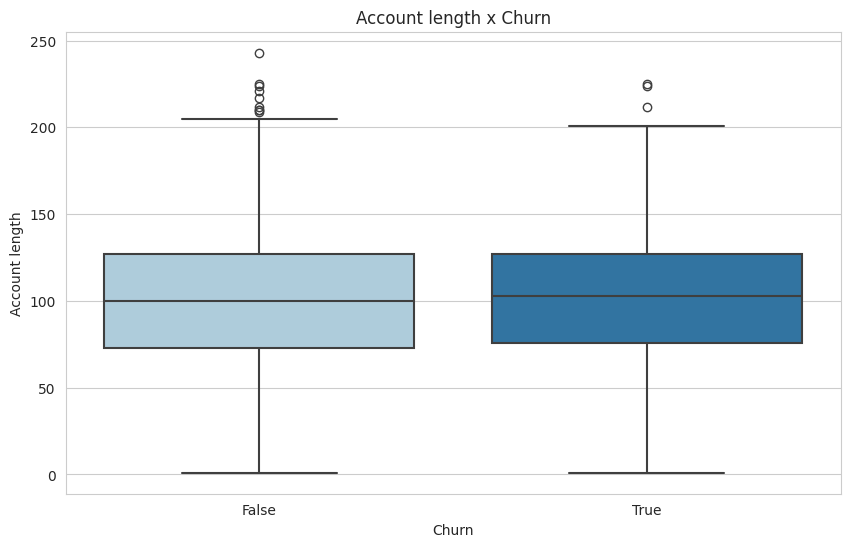

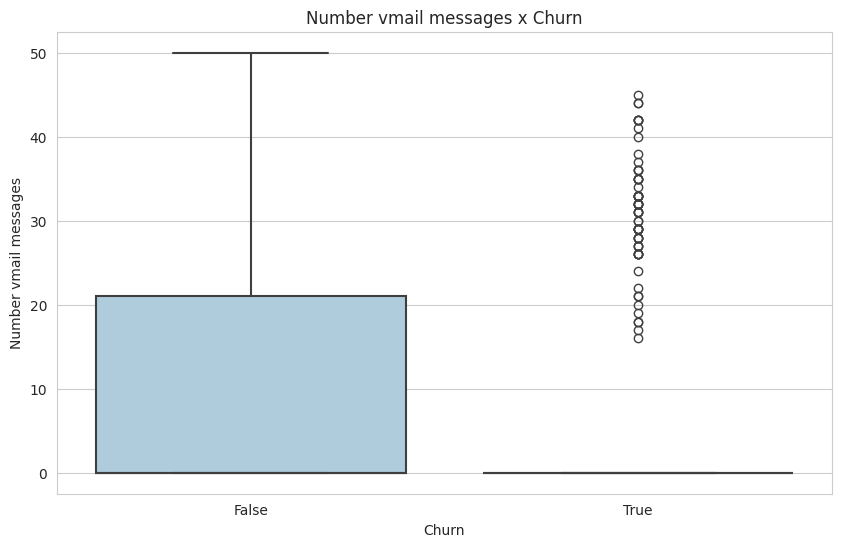

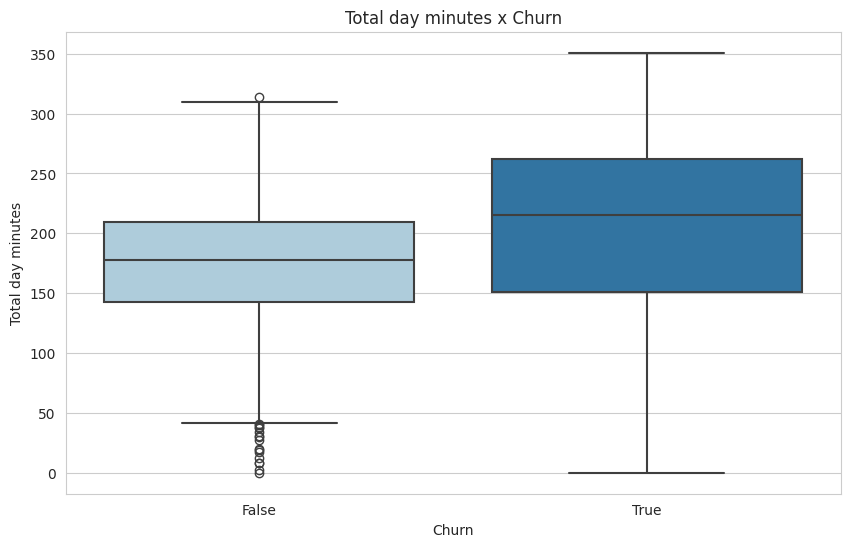

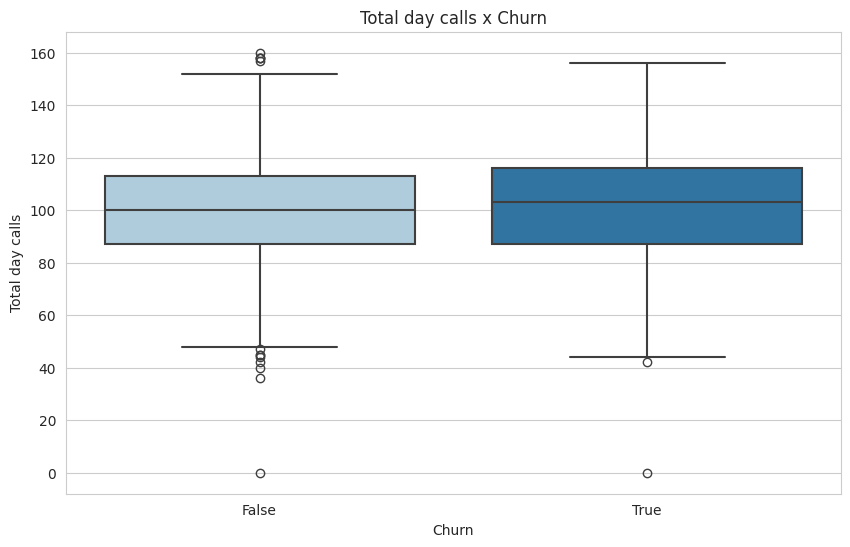

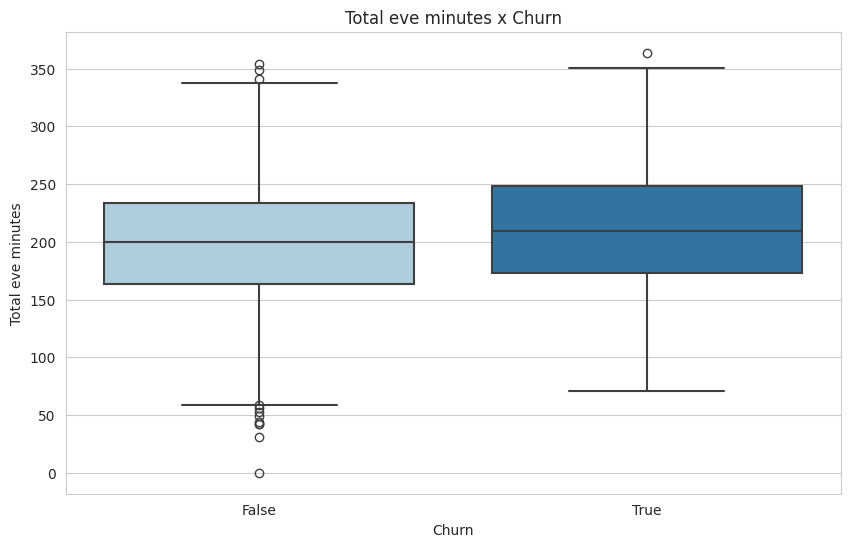

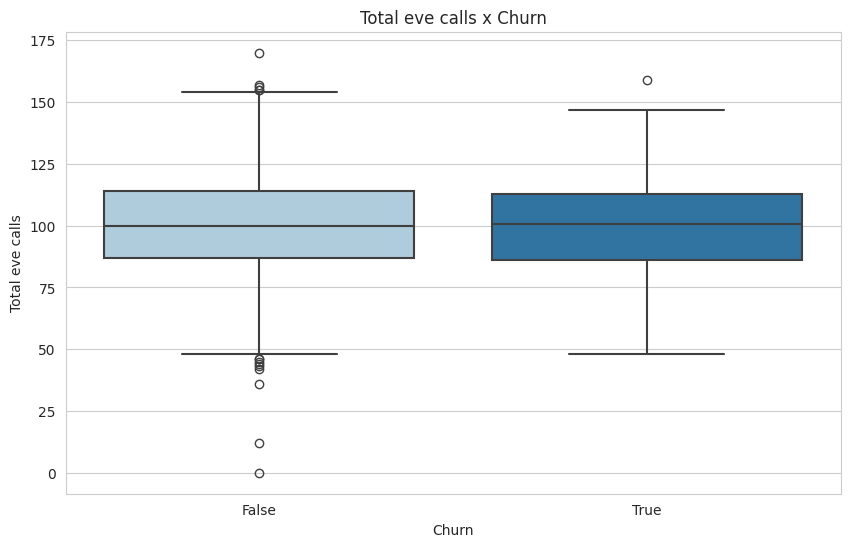

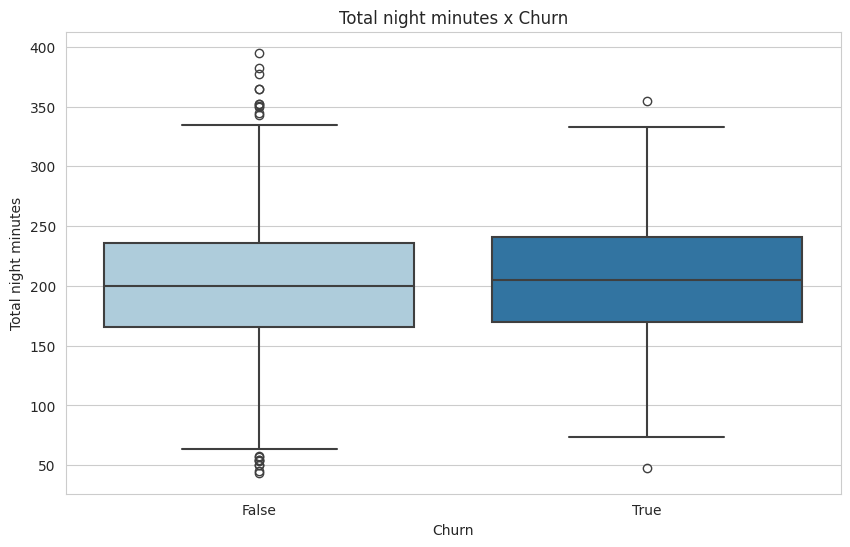

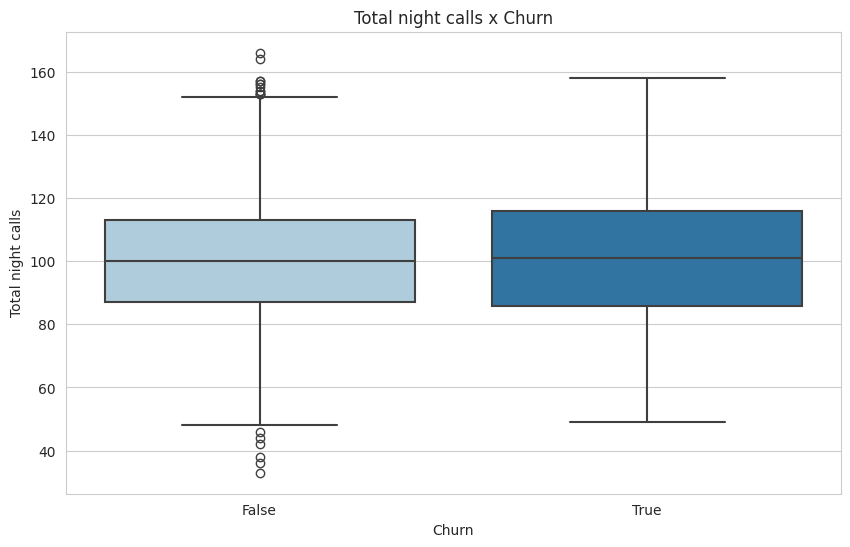

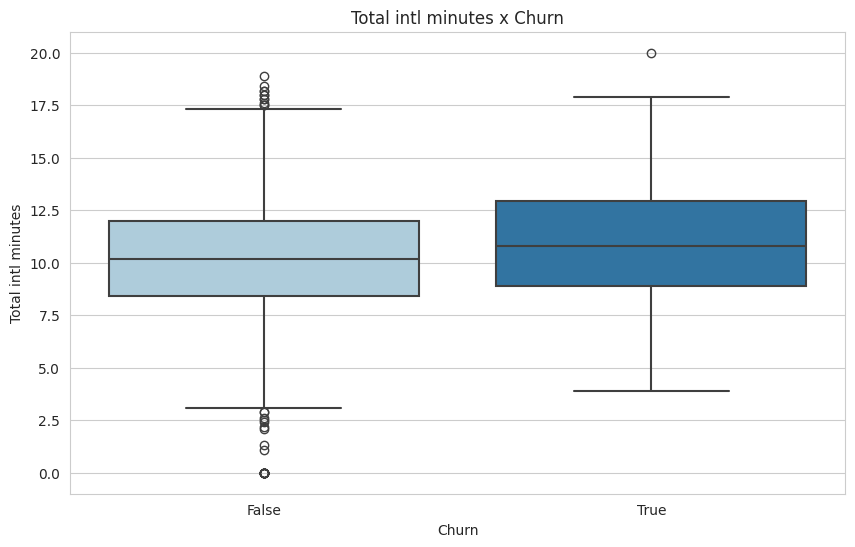

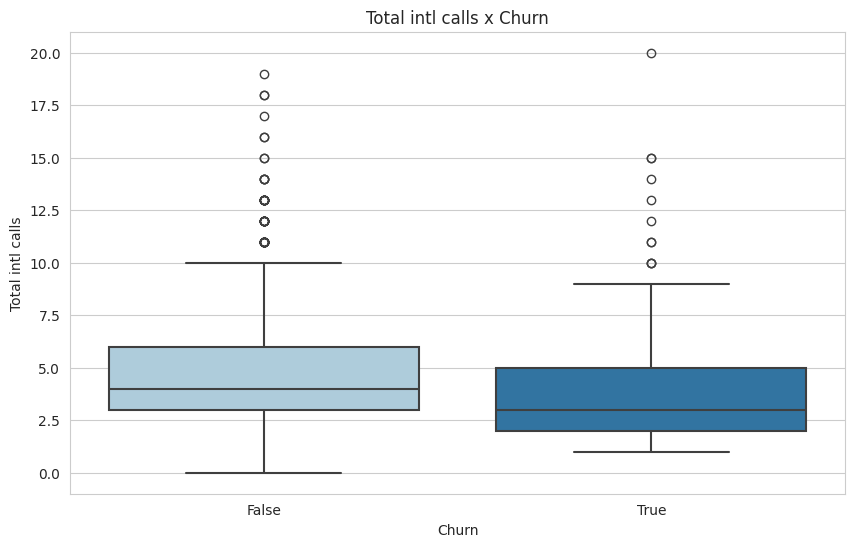

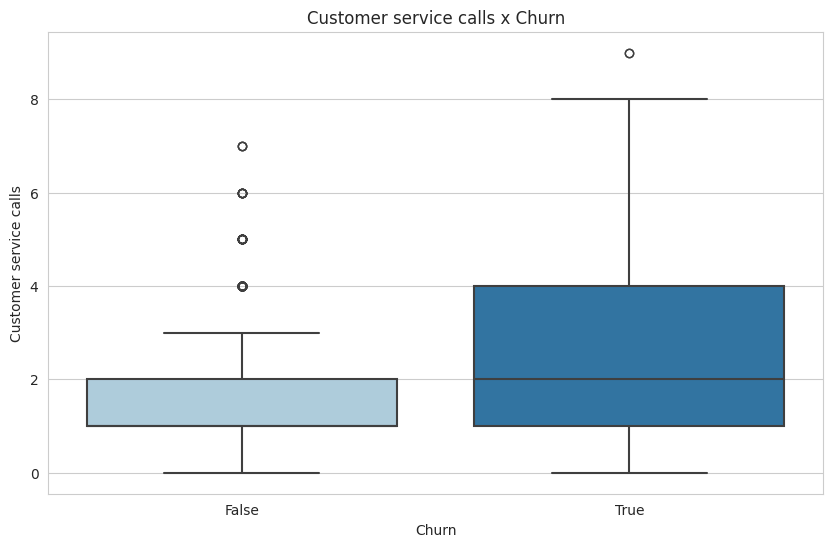

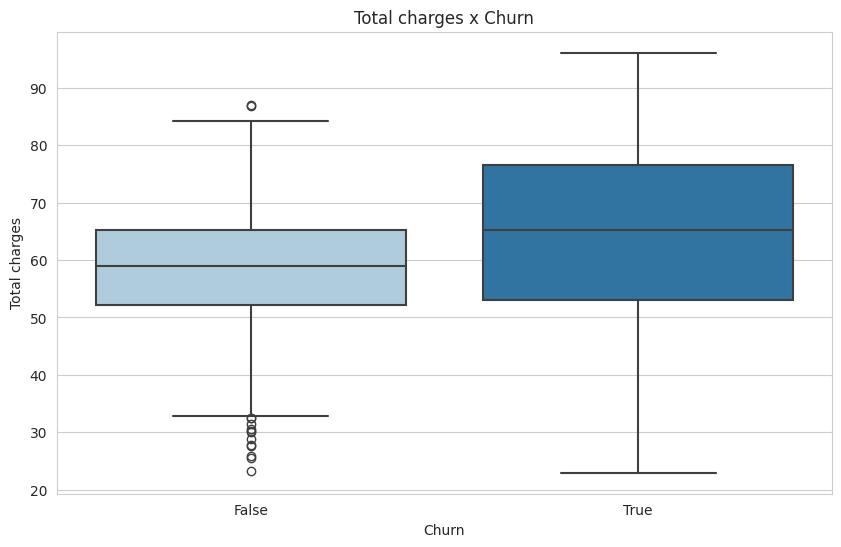

In [154]:
#Plota os boxplots das variáveis numéricas x Churn
sns.set_style('whitegrid')
for col in train.select_dtypes(exclude=['object', 'bool']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=col, data=train, linewidth=1.5, palette='Paired')
    plt.title(f'{col} x Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
plt.show()

A análise dos boxplots revela a presença de outliers em todas as variáveis numéricas.

Além disso, observamos o seguinte:

- Os clientes que contataram o atendimento ao cliente com mais frequência têm uma tendência maior ao churn.
- Os clientes que utilizam o serviço de mensagens de voz parecem ter uma probabilidade menor de churn.
- Aqueles que realizam um grande volume de chamadas durante o dia tendem a cancelar os serviços.
- Existe uma tendência de churn entre os clientes com valores mais elevados de cobrança total.

Em relação às outras variáveis, não identificamos padrões distintos entre os clientes que cancelaram e os que permaneceram com os serviços.

**Lidando com os outliers das variáveis numéricas**

Os outliers detectados para as variáveis numéricas são valores que extrapolam os limites estabelecidos por -1.5 * IQR e 1.5 * IQR. No entanto, é importante ressaltar que isso não necessariamente significa que sejam dados provenientes de algum erro, levando em consideração o contexto. Dado o número limitado de dados para o treinamento e como não podemos afirmar que esses dados não são importantes para a análise, usaremos dois dataframes: "train" e "train_without_outliers", no qual os outliers serão tratado com base nos limites dos whiskers.

In [155]:
def handle_outliers_by_iqr(df):
    df_copy = df.copy()  #Para evitar alterações no DataFrame original

    for col in df_copy.select_dtypes(exclude=['object', 'bool']).columns:
        first_quartile = df_copy[col].quantile(0.25)
        third_quartile = df_copy[col].quantile(0.75)
        IQR = third_quartile - first_quartile

        min_value = first_quartile - 1.5 * IQR
        max_value = third_quartile + 1.5 * IQR

        #Substitui os valores que ultrapassam os limites pelos valores dos limites
        df_copy[col] = df_copy[col].clip(lower=min_value, upper=max_value)

    return df_copy


In [156]:
train_without_outliers = handle_outliers_by_iqr(train)

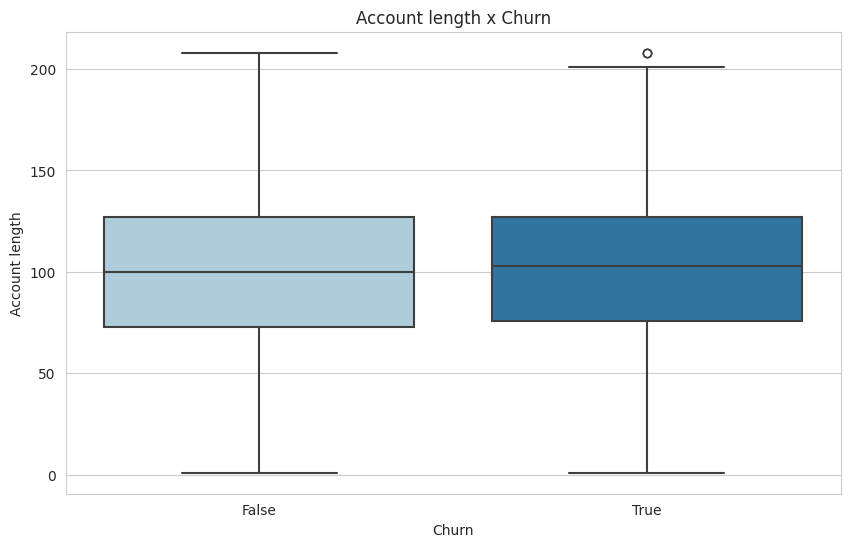

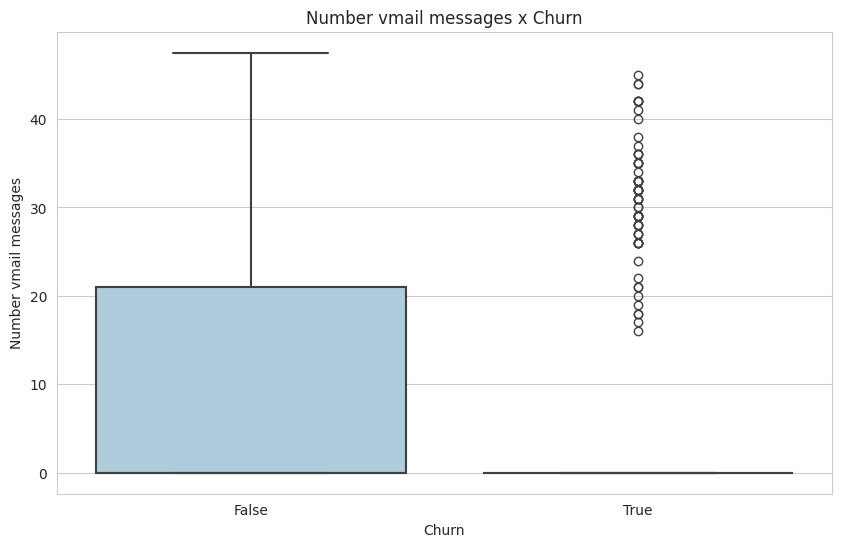

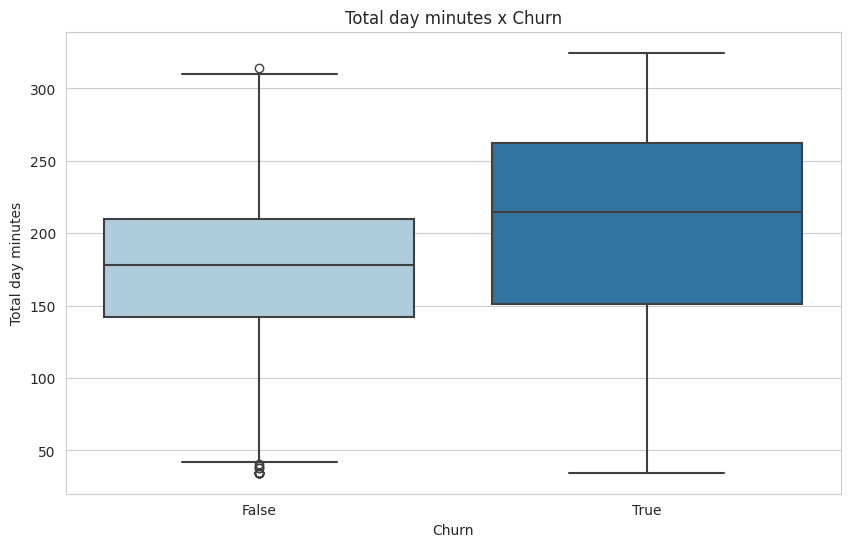

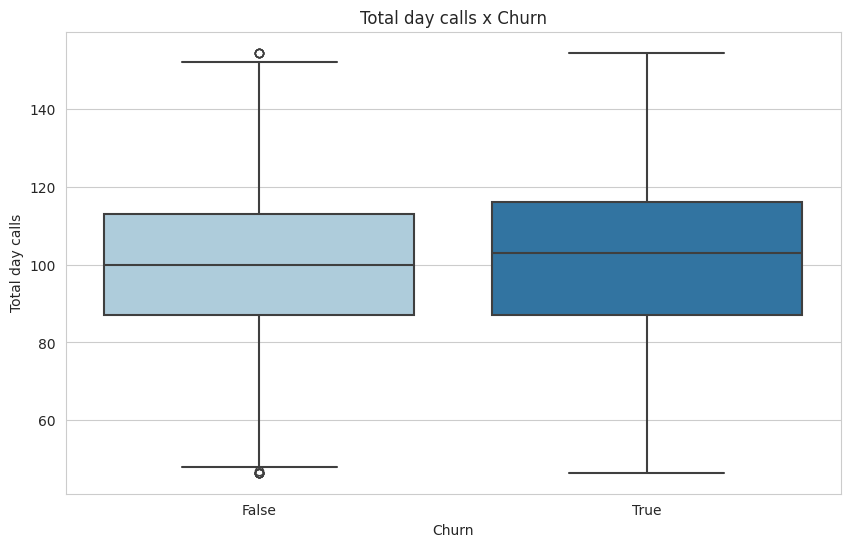

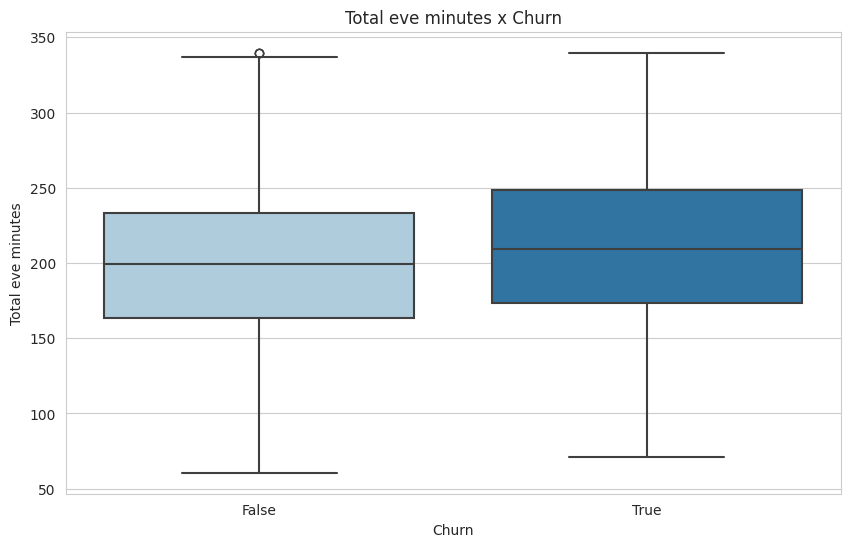

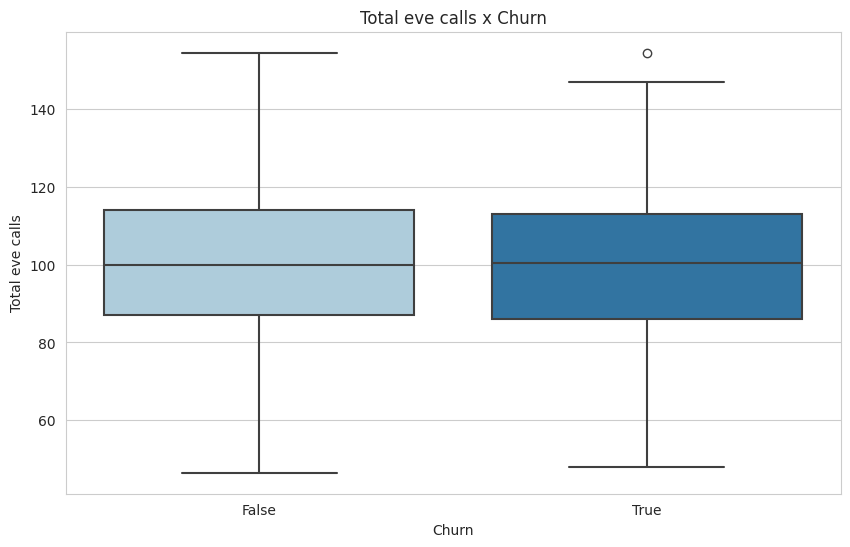

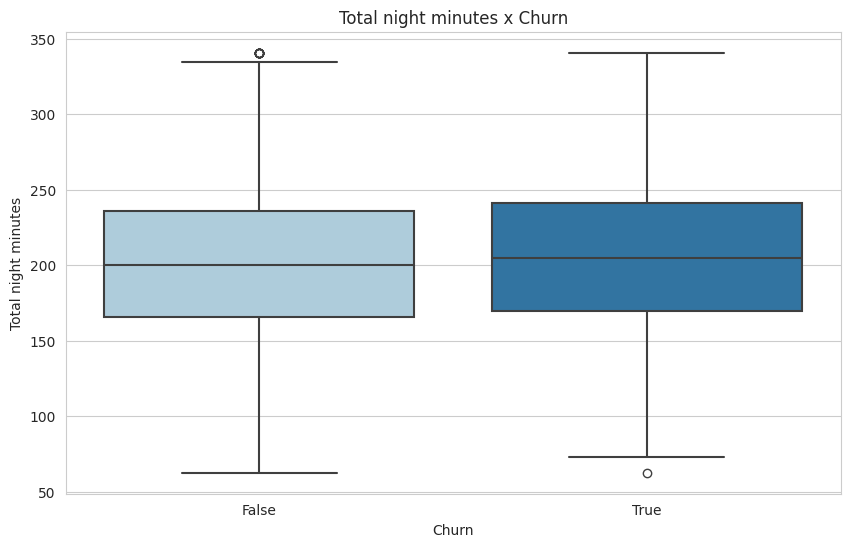

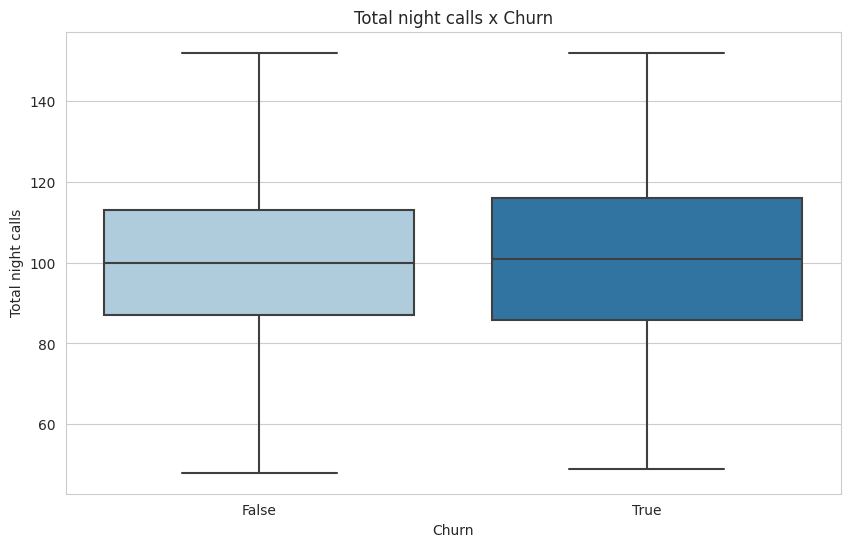

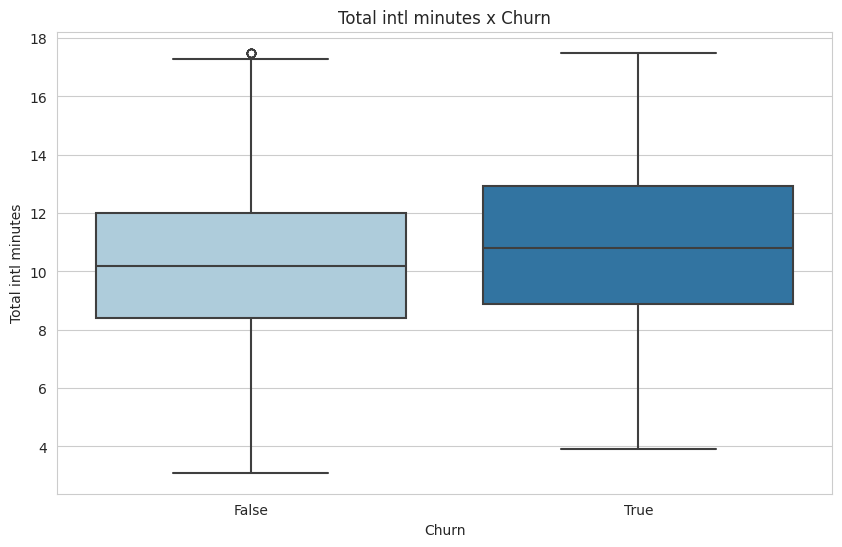

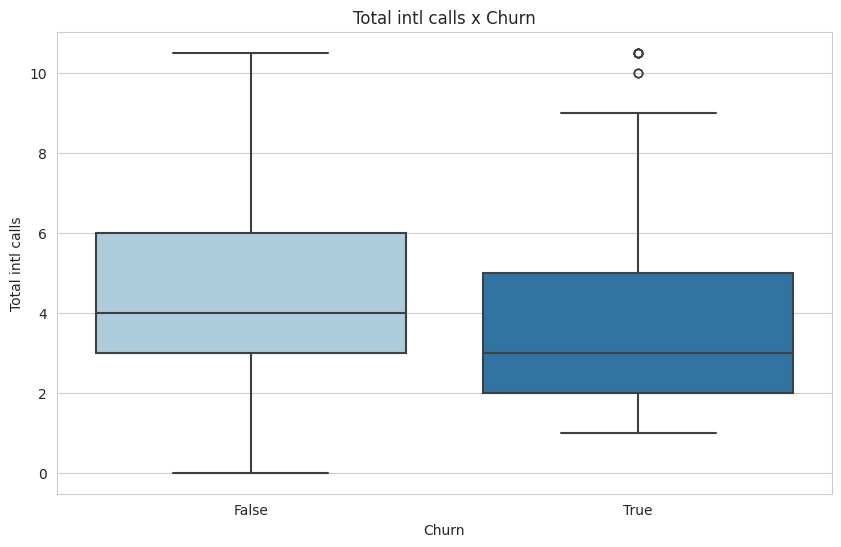

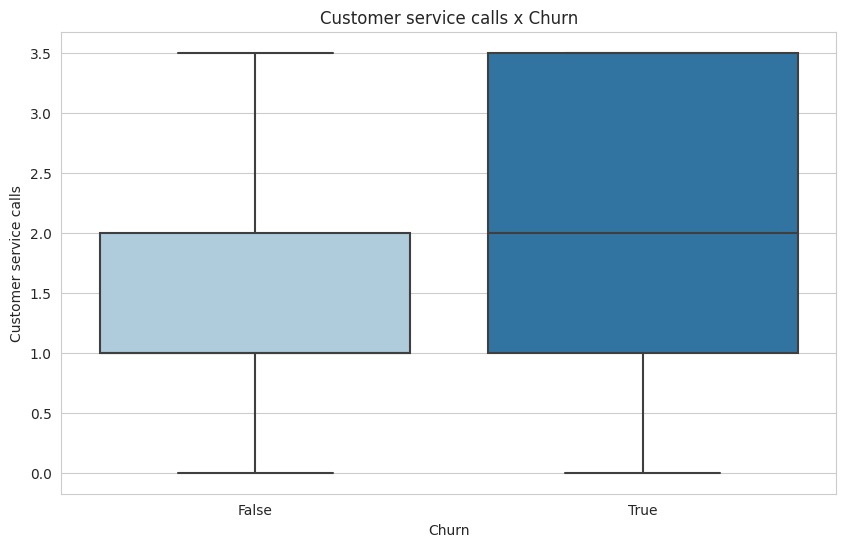

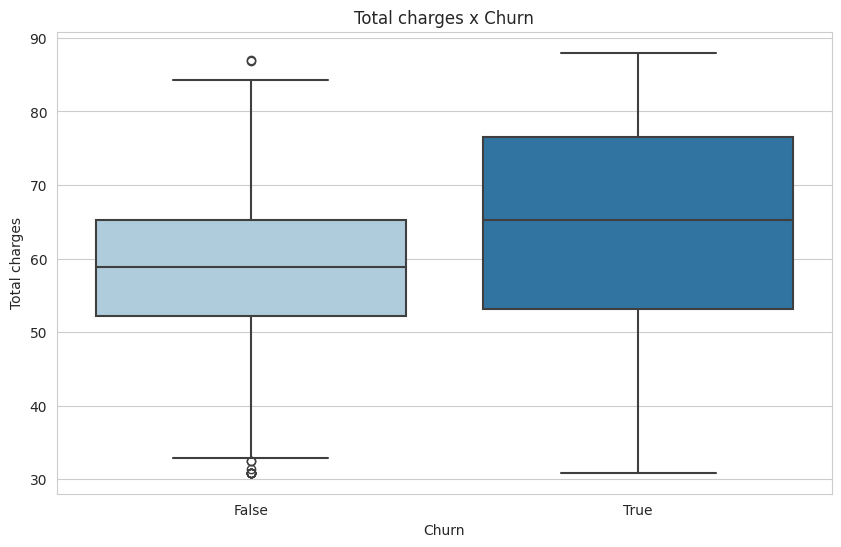

In [157]:
#Plota os boxplots das variáveis numéricas x Churn
sns.set_style('whitegrid')
for col in train_without_outliers.select_dtypes(exclude=['object', 'bool']).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=col, data=train_without_outliers, linewidth=1.5, palette='Paired')
    plt.title(f'{col} x Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
plt.show()

**Variáveis categóricas x Churn**

In [158]:
#Função que calcula as porcentagens de churn e no churn para cada classe de uma variável categórica
def get_percentages(df, categorical_var):

    #Conta o número total de ocorrências para cada categoria da variável categórica
    total_counts = df.groupby(categorical_var)['Churn'].count()

    #Conta o número de churn e no churn para cada categoria e rearranja os dados em um DataFrame
    churn_counts = df.groupby([categorical_var, 'Churn']).size().unstack()

    #Calcula as porcentagens de churn e no churn para cada categoria
    percentages = churn_counts.div(total_counts, axis=0)
    return percentages

*State x Churn*

Vamos examinar o churn a partir da variável "State" apenas através das porcentagens  de False e True, pois o uso de um gráfico é inviável devido ao grande número de categorias.

In [164]:
churn_percentages_by_state = get_percentages(train, 'State')
churn_percentages_by_state.sort_values(by=True, ascending=False)

Churn,False,True
State,,
TX,0.709091,0.290909
NJ,0.720000,0.280000
AR,0.765957,0.234043
MD,0.766667,0.233333
MS,0.770833,0.229167
SC,0.775510,0.224490
ME,0.775510,0.224490
MI,0.775862,0.224138
PA,0.777778,0.222222


Podemos observar uma certa variação na taxa de churn entre os diferentes estados, o que sugere que a variável "State" pode influenciar o churn. No entanto, é importante notar que essa variável tem uma alta cardinalidade. Se usarmos todas as suas categorias para criar variáveis dummy, acabaríamos adicionando 51 novas colunas ao conjunto de dados, o que pode não ser prático para modelos de aprendizado de máquina. Portanto, optamos por remover essa coluna. Mesmo que um método de codificação que reduza sua dimensionalidade, como o hashing encoder, fosse usado, ainda perderíamos muita informação e a variável "State" não teria a mesma relevância para o churn.

In [82]:
#Remoção da coluna "State" dos dados de treinamento e teste
train.drop(columns=['State'], inplace=True)
test.drop(columns=['State'], inplace=True)
train_without_outliers.drop(columns=['State'], inplace=True)
train.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,Total charges
0,128,415,No,Yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False,75.56
1,107,415,No,Yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False,59.24
2,137,415,No,No,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False,62.29
3,84,408,Yes,No,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False,66.80
4,75,415,Yes,No,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False,52.09


*State x ('Area code', 'Voice mail plan', 'International plan')*

In [83]:
def plot_grouped_bar(df, categorical_var):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=categorical_var, hue='Churn', data=df)
    plt.title(f'{categorical_var} x Churn')
    plt.xlabel(categorical_var)
    plt.ylabel('Frequência')
    plt.legend(title='Churn', loc='upper right')

    # Calcular as porcentagens
    percentages = get_percentages(df, categorical_var)
    print(percentages)
    percentages = percentages.values.flatten().tolist()


    # Ordenar as barras por x e filtrar as barras com altura maior que 0
    patches_sorted = sorted(ax.patches, key=lambda p: p.get_x())
    patches_filtered = [p for p in patches_sorted if p.get_height() > 0]


    # Adicionar porcentagem em cada barra
    for p, perc in zip(patches_filtered, percentages):
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2., height + 3, f'{perc:.2%}', ha="center")

    if(categorical_var == 'Voice mail plan'):
      new_labels = ax.get_xticklabels()[::-1]
      ax.set_xticklabels(new_labels)

    plt.show()


Churn         False     True 
Area code                    
408        0.859492  0.140508
415        0.852049  0.147951
510        0.854197  0.145803


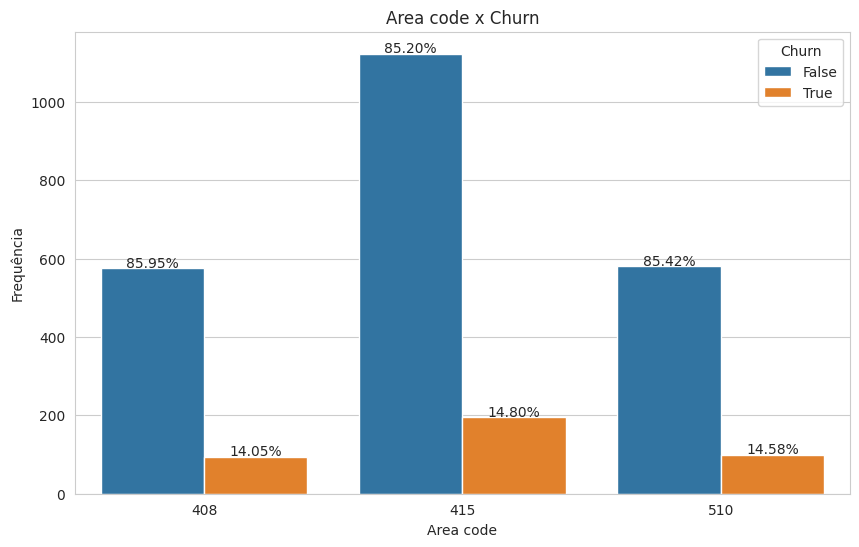

Churn                  False     True 
International plan                    
No                  0.887312  0.112688
Yes                 0.562963  0.437037


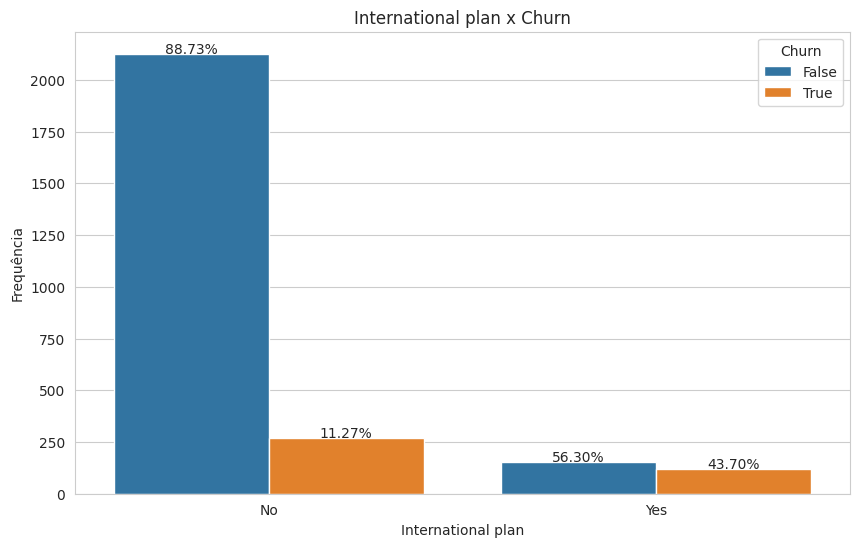

Churn               False     True 
Voice mail plan                    
No               0.832902  0.167098
Yes              0.911323  0.088677


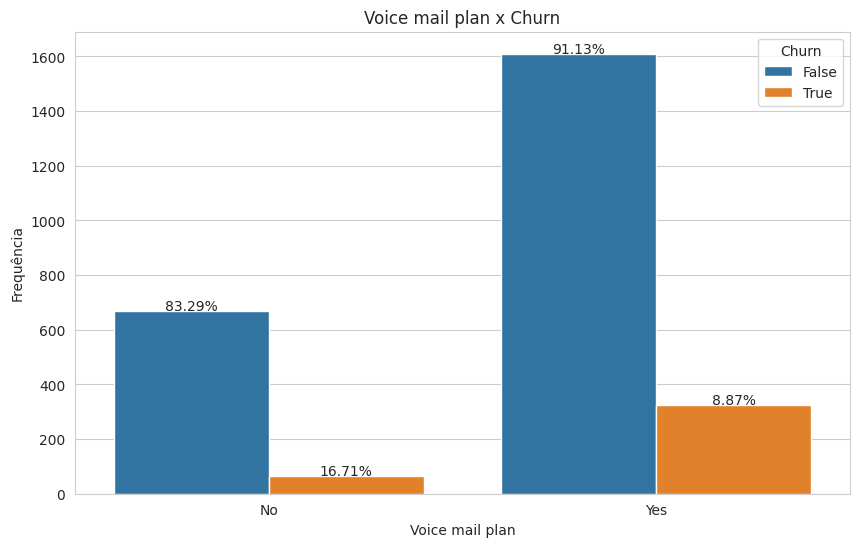

In [84]:
for col in train.select_dtypes(include='object').columns:
    plot_grouped_bar(train, col)

Podemos observar que a proporção de churn e no churn entre as categorias da variável **"Area code"** varia muito pouco. Isso sugere que essa variável pode não ter uma grande influência na decisão de churn de um cliente. Portanto, é interessante considerar a **remoção dela da análise**.

Além disso, notamos que os clientes que possuem um plano internacional tendem mais ao churn em comparação com aqueles que não possuem. Mais de 43% dos clientes com plano internacional cancelaram os serviços, enquanto essa porcentagem é de apenas 11% para aqueles sem o plano.

Também é possível observar que os clientes que não assinam o plano de voice mail têm uma maior propensão ao churn em comparação com aqueles que assinam. O churn rate dos primeiros é quase o dobro dos segundos.

In [85]:
#Remoção da coluna "Area code" dos dados de treinamento e teste
train.drop(columns=['Area code'], inplace=True)
test.drop(columns=['Area code'], inplace=True)
train_without_outliers.drop(columns=['Area code'], inplace=True)
train.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,Total charges
0,128,No,Yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False,75.56
1,107,No,Yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False,59.24
2,137,No,No,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False,62.29
3,84,Yes,No,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False,66.80
4,75,Yes,No,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False,52.09


## Feature Engineering

Nessa etapa, vamos realizar as seguintes ações:

- Converter as variáveis categóricas em numéricas.
- Normalizar as variáveis numéricas para garantir consistência nos dados.
- Organizar os dados para o treinamento do modelo (X e y).
- Lidar com o desbalanceamento dos dados.

Separamos as características do conjunto de dados em variáveis categóricas e numéricas para simplificar as transformações subsequentes.

In [86]:
cat_train = train.select_dtypes(include=['object', 'bool'])
num_train = train.select_dtypes(exclude=['object', 'bool'])
cat_train_without_outliers = train_without_outliers.select_dtypes(include=['object', 'bool'])
num_train_without_outliers = train_without_outliers.select_dtypes(exclude=['object', 'bool'])
num_test = test.select_dtypes(exclude=['object', 'bool'])
col_names_num = train.select_dtypes(exclude=['object', 'bool']).columns

**Conversão das variáveis categóricas**

Para as variáveis categóricas binárias, faremos o mapeamento dos valores "yes/no" e "True/False" para 0 e 1.

In [87]:
#Conversão das variáveis binárias
for df in [cat_train, cat_train_without_outliers, test]:
  df["Churn"] = df["Churn"].astype('int')
  df[['International plan', 'Voice mail plan']] = df[['International plan', 'Voice mail plan']].replace({'Yes': 1, 'No': 0})

cat_train.head()

,International plan,Voice mail plan,Churn
0,0,1,0
1,0,1,0
2,0,0,0
3,1,0,0
4,1,0,0


**Normalização dos dados numéricos**

Para garantir que todos os dados estejam na mesma escala e não haja priorização indevida pelo modelo, optaremos pelo MinMaxScaler. Com essa abordagem, os valores do conjunto de dados serão ajustados para variar entre 0 e 1, proporcionando consistência na interpretação das características.

In [89]:
#Cria um minmaxscaler para cada dataframe
scaler_nt = MinMaxScaler()
scaler_nto = MinMaxScaler()
scaler_test = MinMaxScaler()

In [90]:
#Ajusta os scalers aos dados
scaler_nt.fit(num_train)
scaler_nto.fit(num_train_without_outliers)
scaler_test.fit(num_test)

#Normalização dos dados numéricos
num_train = scaler_nt.transform(num_train)
num_train_without_outliers = scaler_nto.transform(num_train_without_outliers)
test[num_test.columns] = scaler_test.transform(num_test)

test.head()

,Account length,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,Total charges
0,0.502165,0,0,0.0,0.514267,0.496296,0.967485,0.328244,0.559071,0.360902,0.475410,0.222222,0.125,0,0.709094
1,0.277056,0,0,0.0,0.334630,0.792593,0.575072,0.351145,0.538752,0.518797,0.693989,0.333333,0.500,1,0.415887
2,0.692641,0,0,0.0,0.995460,0.274074,0.859739,0.458015,0.398839,0.646617,0.295082,0.500000,0.500,1,1.000000
3,0.476190,0,0,0.0,0.273995,0.540741,0.284348,0.496183,0.483019,0.473684,0.420765,0.333333,0.250,0,0.214231
4,0.207792,0,0,0.0,0.302853,0.644444,0.532356,0.549618,0.451379,0.360902,0.606557,0.055556,0.125,0,0.345346


In [91]:
#Composição final dos dados na mesma escala

# Convertendo arrays NumPy de volta para dataframes
num_train = pd.DataFrame(num_train, columns=col_names_num)
num_train_without_outliers = pd.DataFrame(num_train_without_outliers, columns=col_names_num)


#Concatenando os dataframes
train = pd.concat([num_train.reset_index(drop=True), cat_train.reset_index(drop=True)], axis=1)
train_without_outliers = pd.concat([num_train_without_outliers.reset_index(drop=True), cat_train_without_outliers.reset_index(drop=True)], axis=1)

train.head()

,Account length,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Total charges,International plan,Voice mail plan,Churn
0,0.524793,0.50,0.755701,0.68750,0.542755,0.582353,0.572161,0.436090,0.500,0.15,0.111111,0.718793,0,1,0
1,0.438017,0.52,0.460661,0.76875,0.537531,0.605882,0.599772,0.526316,0.685,0.15,0.111111,0.495903,0,1,0
2,0.561983,0.00,0.693843,0.71250,0.333242,0.647059,0.338457,0.533835,0.610,0.25,0.000000,0.537558,0,0,0
3,0.342975,0.00,0.853478,0.44375,0.170195,0.517647,0.436095,0.421053,0.330,0.35,0.222222,0.599153,1,0,0
4,0.305785,0.00,0.475200,0.70625,0.407754,0.717647,0.407629,0.661654,0.505,0.15,0.333333,0.398252,1,0,0


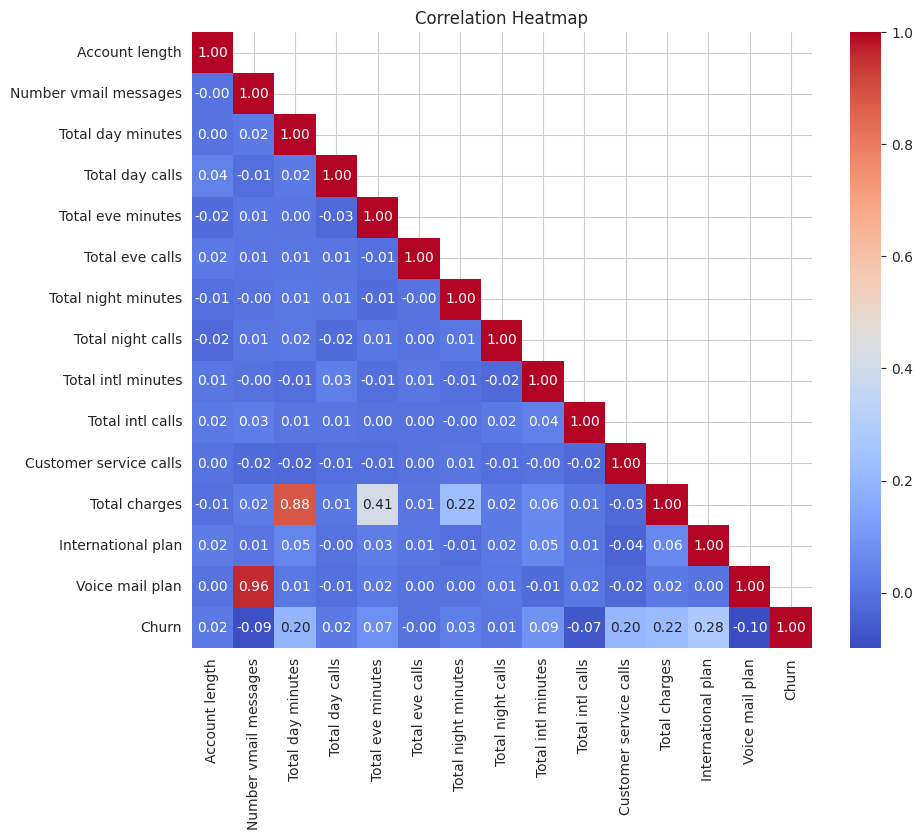

In [92]:
plot_corr_heatmap(train)

Para evitar multicolinearidade no modelo devido à alta correlação entre as variáveis "Voice mail plan" e "Number vmail messages" e "Total day minutes", optamos por remover uma de cada par.

In [93]:
train.drop(columns=['Number vmail messages', 'Total day minutes'], inplace=True)
train_without_outliers.drop(columns=['Number vmail messages', 'Total day minutes'], inplace=True)
test.drop(columns=['Number vmail messages', 'Total day minutes'], inplace=True)

**Separandos os dados em features e target**

In [94]:
train.columns

Index(['Account length', 'Total day calls', 'Total eve minutes',
       'Total eve calls', 'Total night minutes', 'Total night calls',
       'Total intl minutes', 'Total intl calls', 'Customer service calls',
       'Total charges', 'International plan', 'Voice mail plan', 'Churn'],
      dtype='object')

In [95]:
X_train = train.drop(columns=['Churn'])
y_train = train['Churn']

X_train_wo = train_without_outliers.drop(columns=['Churn'])
y_train_wo = train_without_outliers['Churn']

#Reordenando as colunas dos dados de teste
test = test.reindex(columns=['Account length', 'Total day calls', 'Total eve minutes',
       'Total eve calls', 'Total night minutes', 'Total night calls',
       'Total intl minutes', 'Total intl calls', 'Customer service calls',
       'Total charges', 'International plan', 'Voice mail plan', 'Churn'])

X_test = test.drop(columns=['Churn'])
y_test = test['Churn']

In [96]:
test.head()

,Account length,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Total charges,International plan,Voice mail plan,Churn
0,0.502165,0.496296,0.967485,0.328244,0.559071,0.360902,0.475410,0.222222,0.125,0.709094,0,0,0
1,0.277056,0.792593,0.575072,0.351145,0.538752,0.518797,0.693989,0.333333,0.500,0.415887,0,0,1
2,0.692641,0.274074,0.859739,0.458015,0.398839,0.646617,0.295082,0.500000,0.500,1.000000,0,0,1
3,0.476190,0.540741,0.284348,0.496183,0.483019,0.473684,0.420765,0.333333,0.250,0.214231,0,0,0
4,0.207792,0.644444,0.532356,0.549618,0.451379,0.360902,0.606557,0.055556,0.125,0.345346,0,0,0


**Lidando com o desbalanceamento dos dados**

Com apenas 15% dos dados de treinamento representando o fenômeno de churn, o desequilíbrio de classe é evidente. Para abordar essa questão, optamos por utilizar a técnica de oversampling SMOTE (Synthetic Minority Over-sampling Technique), que cria instâncias sintéticas para a classe minoritária usando a técnica de KNN e interpolação. No entanto, é importante destacar que essa técnica pode levar ao overfitting do modelo, pois as novas amostras usadas para balancear os dados são derivadas dos dados já existentes, portanto, não proporcionam adição de informações verdadeiramente novas.

In [97]:
def resample(X, y):
   #Cria uma instância do SMOTE
   smote = SMOTE()

   #Aplica o SMOTE aos dados
   X_, y_ = smote.fit_resample(X, y)
   count_plot_with_perc('Churn', pd.concat([X_, y_], axis=1))

   return X_, y_

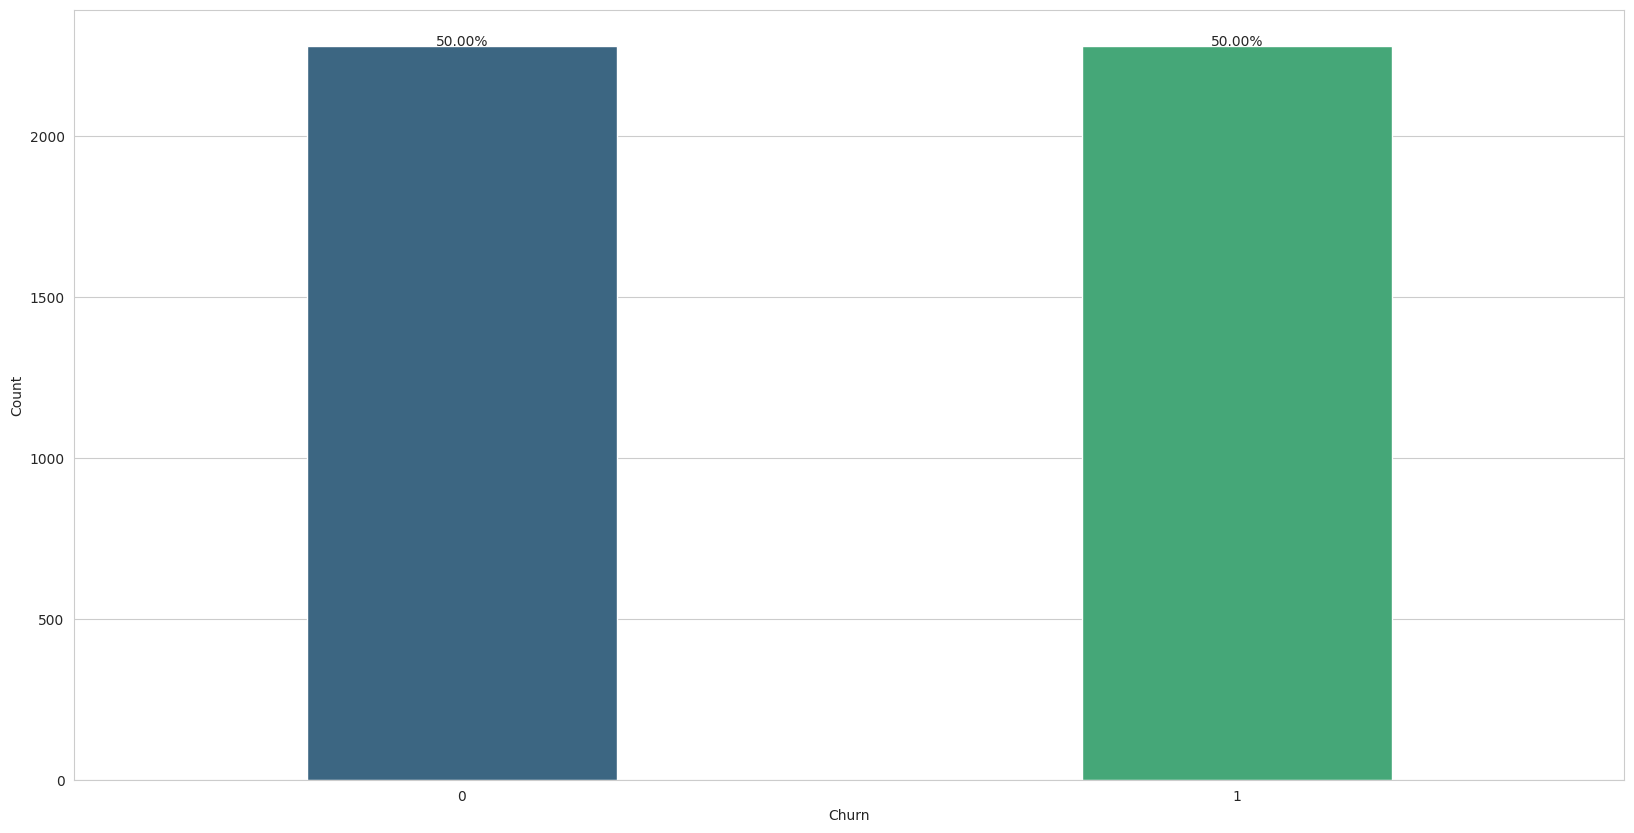

In [98]:
X_train_resampled, y_train_resampled = resample(X_train, y_train)

## Métricas de análise de desempenho dos modelos

Dado o desbalanceamento do dataset original e nossa prioridade em prever corretamente a classe minoritária (churn), não utilizaremos a acurácia como métrica principal de avaliação. Isso ocorre porque a predominância de instâncias da classe "no churn" pode enviesar o modelo para esse resultado, levando a uma acurácia alta que reflete principalmente respostas corretas para a classe majoritária.

Optaremos pelo F1-Score como métrica principal, pois buscamos um equilíbrio entre precisão e recall, mas focaremos no maior valor possível de recall. É crucial que as previsões de churn sejam precisas, e que as instâncias que realmente representam churn sejam corretamente identificadas como tal.

Além do F1-Score, também analisaremos outras métricas como precisão, recall, acurácia e a AUC.


**Funções para avaliar o desempenho do modelo conforme as métricas pré-definidas**

In [227]:
def evaluate_model(model, X, y):
    #Calcula as métricas
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)

    return accuracy, precision, recall, f1, roc_auc

In [228]:
def get_scores(X_validate, y_validate, models):
    #Cria listas para armazenar os resultados
    model_names = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    roc_auc_list = []
    best_parameters = []

    #Avalia e armazena os resultados dos modelos treinados
    for name, model in models.items():
        accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_validate, y_validate)


        #Adiciona os resultados às listas
        model_names.append(name)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_auc_list.append(roc_auc)

    #Cria um dataframe com os resultados
    results = pd.DataFrame({
        'Modelo': model_names,
        'Acurácia': accuracy_list,
        'Precisão': precision_list,
        'Recall': recall_list,
        'F1': f1_list,
        'ROC AUC': roc_auc_list
    })

    return results

## Modelos analisados

Vamos analisar alguns modelos clássicos usados para problemas de classificação.

- KNN
- Logistic Regression
- Gradient Boosting
- Decision Forest
- Random Forest
- SVC
- XGBoost

Refinamos um processo para treinar os modelos que serão avaliados, ajustando os parâmetros para otimizar o desempenho com base nos dados específicos do problema. Em seguida, avaliamos o desempenho dos modelos por meio de métricas definidas anteriormente.


In [229]:
def train_models(x_train, y_train):
    #Define os modelos
    models = {
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVC': SVC(),
        'XGBoost': XGBClassifier()
    }

    #Define os parâmetros do GridSearch para cada modelo
    param_grid = {
        'KNN': {'n_neighbors': [3, 5, 7]},
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'Gradient Boosting': {'n_estimators': [50, 100, 200]},
        'Random Forest': {'n_estimators': [50, 100, 200]},
        'Decision Tree': {'max_depth': [3, 5, 7]},
        'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'XGBoost': {'n_estimators': [50, 100, 200, 500]}
    }

    best_models = {}
    best_scores = {}

    #Treino e otimização dos modelos
    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grid[name], cv=10, scoring='f1')
        grid_search.fit(x_train, y_train)
        best_models[name] = grid_search.best_estimator_
        best_scores[name] = grid_search.best_score_

    return best_models, best_scores

## Treinamento

Vamos treinar os modelos e calcular os scores para três cenários distintos:
- Dados desbalanceados com outliers
- Dados desbalanceados sem outliers
- Dados balanceados com outliers

**Treinamento usando dados desbalanceados com outliers**

In [102]:
# Usando a função para treinar os modelos
best_models_original, scores = train_models(X_train, y_train)
scores

{'KNN': 0.5241614949427094,
 'Logistic Regression': 0.309705912231043,
 'Gradient Boosting': 0.9195250936377602,
 'Random Forest': 0.9181427481747846,
 'Decision Tree': 0.9057916933489174,
 'SVC': 0.6590776442465858,
 'XGBoost': 0.9130469594382637}

In [103]:
best_models_original

{'KNN': KNeighborsClassifier(n_neighbors=3),
 'Logistic Regression': LogisticRegression(C=10),
 'Gradient Boosting': GradientBoostingClassifier(n_estimators=50),
 'Random Forest': RandomForestClassifier(n_estimators=200),
 'Decision Tree': DecisionTreeClassifier(max_depth=5),
 'SVC': SVC(C=10),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n

É evidente que os modelos que obtiveram os melhores resultados de f1 score foram aqueles baseados em árvores de decisão e técnicas de ensemble do tipo boosting. Esses modelos são conhecidos por lidar de forma mais eficaz com conjuntos de dados desbalanceados. No caso dos dados originais, os modelos que se destacaram foram o Gradient Boosting e o Random Forest.

**Treinamento usando os dados desbalanceados sem outliers**

In [104]:
best_models_wo, scores = train_models(X_train_wo, y_train_wo)
scores

{'KNN': 0.44606235883061707,
 'Logistic Regression': 0.2996691719712657,
 'Gradient Boosting': 0.9170472601295339,
 'Random Forest': 0.9179046529366894,
 'Decision Tree': 0.8993021641750578,
 'SVC': 0.6872658383143558,
 'XGBoost': 0.9157831635880112}

In [105]:
best_models_wo

{'KNN': KNeighborsClassifier(n_neighbors=3),
 'Logistic Regression': LogisticRegression(C=10),
 'Gradient Boosting': GradientBoostingClassifier(n_estimators=200),
 'Random Forest': RandomForestClassifier(n_estimators=200),
 'Decision Tree': DecisionTreeClassifier(max_depth=5),
 'SVC': SVC(C=10),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, 

Detecta-se uma leve variação no desempenho dos modelos após o tratamento dos outliers nos dados.

**Treinamento usando dados balanceados**

In [106]:
best_models_resampled, scores = train_models(X_train_resampled, y_train_resampled)
scores

{'KNN': 0.9186301608424152,
 'Logistic Regression': 0.7543870118909819,
 'Gradient Boosting': 0.9732266432039062,
 'Random Forest': 0.9687602498970411,
 'Decision Tree': 0.9217003880421475,
 'SVC': 0.9006736005003237,
 'XGBoost': 0.98473875584111}

In [107]:
best_models_resampled

{'KNN': KNeighborsClassifier(n_neighbors=3),
 'Logistic Regression': LogisticRegression(C=10),
 'Gradient Boosting': GradientBoostingClassifier(n_estimators=200),
 'Random Forest': RandomForestClassifier(),
 'Decision Tree': DecisionTreeClassifier(max_depth=7),
 'SVC': SVC(C=10),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=None,
   

O ajuste dos modelos aos dados que passaram por oversampling resultou em um aumento considerável de sua performance, o que é positivo. No entanto, esse ganho significativo pode ser um indício de overfitting, uma ocorrência comum ao utilizar essa técnica de resampling.

## Avaliação dos modelos com os dados de teste

Churn no conjunto de teste

In [108]:
print(f"Número de clientes afetados pelo churn: {len(test[test['Churn'] == 1])}")
print(f"churn_rate: {len(test[test['Churn'] == 1])/len(test)*100:.2f}%")

Número de clientes afetados pelo churn: 95
churn_rate: 14.24%


**Modelos treinados com dados desbalanceados e com outliers**

In [109]:
get_scores(X_test, y_test, best_models_original)

,Modelo,Acurácia,Precisão,Recall,F1,ROC AUC
0,KNN,0.886057,0.655738,0.421053,0.512821,0.692170
1,Logistic Regression,0.854573,0.478261,0.231579,0.312057,0.594810
2,Gradient Boosting,0.959520,0.846939,0.873684,0.860104,0.923730
3,Random Forest,0.964018,0.873684,0.873684,0.873684,0.926353
4,Decision Tree,0.958021,0.838384,0.873684,0.855670,0.922856
5,SVC,0.926537,0.780488,0.673684,0.723164,0.821108
6,XGBoost,0.964018,0.873684,0.873684,0.873684,0.926353


Os modelos que apresentaram melhores resultados para a métrica f1 foram o XGBoost e o Random Forest, mas os outros modelos baseados em Decision Trees também tiveram performances próximas.

**Modelos treinados com dados desbalanceados e sem outliers**

In [110]:
get_scores(X_test, y_test, best_models_wo)

,Modelo,Acurácia,Precisão,Recall,F1,ROC AUC
0,KNN,0.871064,0.609756,0.263158,0.367647,0.617593
1,Logistic Regression,0.854573,0.444444,0.084211,0.141593,0.533364
2,Gradient Boosting,0.898051,0.721311,0.463158,0.564103,0.716719
3,Random Forest,0.898051,0.721311,0.463158,0.564103,0.716719
4,Decision Tree,0.898051,0.721311,0.463158,0.564103,0.716719
5,SVC,0.898051,0.736842,0.442105,0.552632,0.707941
6,XGBoost,0.892054,0.671642,0.473684,0.555556,0.717611


**Modelos treinados com dados balanceados e com outliers**

In [111]:
get_scores(X_test, y_test, best_models_resampled)

,Modelo,Acurácia,Precisão,Recall,F1,ROC AUC
0,KNN,0.826087,0.432258,0.705263,0.536000,0.775709
1,Logistic Regression,0.761619,0.346154,0.757895,0.475248,0.760066
2,Gradient Boosting,0.446777,0.198238,0.947368,0.327869,0.655502
3,Random Forest,0.881559,0.551948,0.894737,0.682731,0.887054
4,Decision Tree,0.808096,0.417910,0.884211,0.567568,0.839833
5,SVC,0.896552,0.614035,0.736842,0.669856,0.829960
6,XGBoost,0.593703,0.248571,0.915789,0.391011,0.728000


Os modelos treinados com dados balanceados e desbalanceados e sem outliers, exibiram uma significativa queda de desempenho. Esse fenômeno pode ser atribuído a um possível overfitting gerado pelo processo de resampling nos dados balanceados, enquanto para o segundo caso, a perda de informação devido ao tratamento dos outliers pode ter sido um fator contribuinte.

**Destaca-se que os modelos XGBoost e Random Forest, treinados com os dados desbalanceados e sem outliers, apresentaram a melhor performance. Assim, optaremos por utilizar um deles para realizar as previsões em benefício da empresa.**

In [114]:
best_models_original['XGBoost']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [206]:
best_models_original['Random Forest']

RandomForestClassifier(n_estimators=200)

## Modelo Final

In [217]:
model = best_models_original['Random Forest']

y_predicted = model.predict(X_test)

**Verificação das previsões incorretas**

In [218]:
diff = y_predicted - y_test
churn_wrong_pred = np.sum(diff < 0)
print(f"Número de previsões incorretas para o churn: {churn_wrong_pred}, o que representa aproximadamente {churn_wrong_pred/95*100:.2f}% das previsões para o churn.")

Número de previsões incorretas para o churn: 12, o que representa aproximadamente 12.63% das previsões para o churn.


In [219]:
no_churn_wrong_pred = np.sum(diff > 0)
print(f"Número de previsões incorretas para o no churn: {no_churn_wrong_pred}, o que representa aproximadamente {no_churn_wrong_pred/95*100:.2f}% das previsões para o no churn.")

Número de previsões incorretas para o no churn: 12, o que representa aproximadamente 12.63% das previsões para o no churn.


**Plotando a curva ROC**

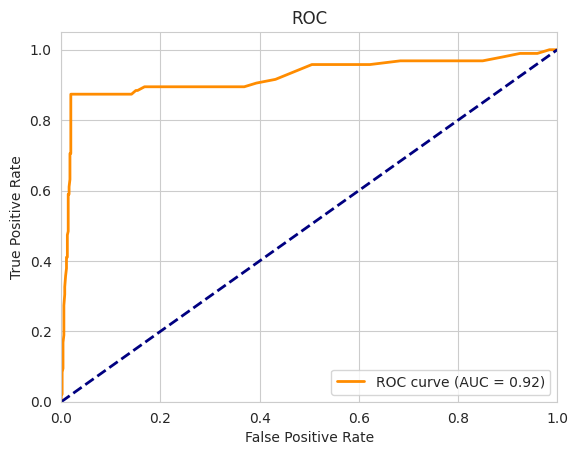

In [220]:
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

#Plota a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

**Feature Importance**

In [221]:
importances = model.feature_importances_

#Ordena as features pela importância
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X_train.columns[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

for feature, importance in zip(sorted_features, sorted_importances):
    print(f'{feature}: {importance}')

Total charges: 0.3440161478352493
Customer service calls: 0.12545127177242746
International plan: 0.09194899773150243
Total intl minutes: 0.07200958808151826
Total intl calls: 0.057061425282234964
Total eve minutes: 0.0519601960640393
Voice mail plan: 0.04704145720784785
Total night minutes: 0.04312088140184303
Account length: 0.04182334889105461
Total day calls: 0.03951862385029592
Total night calls: 0.03719063266522685
Total eve calls: 0.036200648669914307
High churn state: 0.012656780546845813


Com base nas análises efetuadas, destacam-se como características mais relevantes para o modelo "Total charges", "International plan" e "Customer service calls". Essa conclusão é corroborada por observações anteriores, as quais indicam que clientes com gastos mais elevados, que aderem ao plano de ligações internacionais e que contatam o suporte ao cliente com frequência têm maior probabilidade de churn.

**Característica comuns das previsões erradas de churn**

In [224]:
incorrect_predictions = X_test[(y_predicted != y_test) & (y_test == 1)]
incorrect_df = pd.DataFrame(incorrect_predictions, columns=X_test.columns)
incorrect_df.describe()

,Account length,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Total charges,High churn state,International plan,Voice mail plan
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.555556,0.530864,0.521438,0.537532,0.503628,0.447995,0.512295,0.268519,0.218750,0.454455,0.333333,0.083333,0.333333
std,0.166257,0.161188,0.197059,0.155745,0.156461,0.163742,0.147442,0.207645,0.108253,0.151083,0.492366,0.288675,0.492366
min,0.203463,0.244444,0.240038,0.229008,0.142816,0.142857,0.306011,0.055556,0.000000,0.213004,0.000000,0.000000,0.000000
25%,0.481602,0.453704,0.364839,0.438931,0.441800,0.300752,0.453552,0.111111,0.125000,0.324567,0.000000,0.000000,0.000000
50%,0.580087,0.529630,0.531240,0.522901,0.522061,0.492481,0.505464,0.250000,0.250000,0.499310,0.000000,0.000000,0.000000
75%,0.660173,0.603704,0.659707,0.690840,0.552032,0.567669,0.571038,0.277778,0.250000,0.543207,1.000000,0.000000,1.000000
max,0.831169,0.844444,0.897992,0.732824,0.768650,0.631579,0.857923,0.833333,0.375000,0.676890,1.000000,1.000000,1.000000


Com base nas previsões incorretas para o churn, observamos que muitos clientes que deveriam ser classificados como churn, mas não foram, têm baixo volume de gastos, não aderiram ao plano internacional e fizeram poucas ligações para o atendimento ao cliente e para chamadas internacionais. Essas características são de alta importância para o modelo e são fortes indicativos de que o cliente não será afetado pelo churn, então esses tipos de erro são esperados para o modelo. Para corrigir isso, seria necessária a inclusão de uma variável que fosse decisiva para casos em que as features mais importantes de agora não têm muita influência ou expor o modelo a casos semelhantes durante o treinamento.

In [223]:
#Mostra a probabilidade de cada classe para as classificações erradas de churn
probabilities = model.predict_proba(X_test)
probabilities[(y_predicted != y_test) & (y_test == 1)]

array([[0.985, 0.015],
       [0.94 , 0.06 ],
       [0.935, 0.065],
       [0.84 , 0.16 ],
       [0.85 , 0.15 ],
       [0.94 , 0.06 ],
       [0.925, 0.075],
       [0.935, 0.065],
       [0.98 , 0.02 ],
       [0.93 , 0.07 ],
       [0.995, 0.005],
       [0.96 , 0.04 ]])

É notável que o modelo está bastante confiante em suas previsões incorretas sobre o churn devido as características contraintuivas, de acordo com a feature importance, que essas amostras apresentaram.

**Salvando o modelo**

In [226]:
joblib.dump(model, 'churn_prediction_model')

['churn_prediction_model']